# HR analytics

## 📌 Project Objectives

This project focuses on two key business problems in HR analytics:

1. **Predicting Employee Satisfaction**  
   Build a supervised machine learning model to estimate the job satisfaction level of an employee based on their profile and performance data.

2. **Predicting Employee Attrition**  
   Develop a predictive model to assess the likelihood of an employee leaving the company, using historical workforce data provided by the cliet.

---


## 🧾 Dataset Description

The dataset contains anonymized HR data for employees. Each row corresponds to one employee, and includes various features related to their role, tenure, performance, and compensation.

| Column Name             | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| `id`                    | Unique identifier for each employee                                         |
| `dept`                  | Department where the employee works                                         |
| `level`                 | Job level or seniority                                                      |
| `workload`              | Current workload level (numeric score)                                      |
| `employment_years`      | Number of years the employee has worked at the company                      |
| `last_year_promo`       | Whether the employee was promoted in the past year (binary: 1 = Yes, 0 = No)|
| `last_year_violations`  | Whether the employee violated any policies in the past year (1 = Yes, 0 = No)|
| `supervisor_evaluation` | Performance score given by the employee’s direct supervisor                 |
| `salary`                | Monthly salary                                                              |
| `job_satisfaction_rate` | Employee’s self-reported job satisfaction level (Target variable for Task 1)|


In [232]:
!pip install -q shap
!pip install -q phik
!pip install -q imblearn

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
import re
import phik
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from sklearn.metrics import (mean_squared_error,
                            mean_absolute_error,
                            r2_score,
                            recall_score,
                            precision_score,
                            accuracy_score,
                            confusion_matrix, roc_auc_score, f1_score, make_scorer)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import math
RANDOM_STATE = 42

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap
shap.initjs()
import math

from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline 

import shap

## Predicting Employee Satisfaction

### Data Load

In [234]:
train_job_satisf = pd.read_csv('https://code.s3.yandex.net//datasets/train_job_satisfaction_rate.csv')

In [235]:
train_job_satisf.head(5)

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [236]:
train_job_satisf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [237]:
test_features = pd.read_csv('https://code.s3.yandex.net//datasets/test_features.csv')

In [238]:
test_features.head(5)

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [239]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [240]:
test_target = pd.read_csv('https://code.s3.yandex.net//datasets/test_target_job_satisfaction_rate.csv')

In [241]:
test_target.head(5)

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [242]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


#### **Data Load Summary**

After loading and inspecting the datasets, we can summarize the initial findings as follows:

- **`train_job_satisf`**  
  - 4,000 rows  
  - Missing values found in: `dept`, `level`  
  - All data types are correctly assigned

- **`test_features`**  
  - 2,000 rows  
  - Missing values found in: `dept`, `level`  
  - All data types are correctly assigned

- **`test_target`**  
  - 2,000 rows  
  - No missing values  
  - Data types are correct

## Data preprocessing

In [243]:
train_job_satisf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [244]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'level']

In [245]:
train_job_satisf.describe()

id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

In [246]:
train_job_satisf['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [247]:
train_job_satisf['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [248]:
train_job_satisf.loc[train_job_satisf['level']=='sinior', 'level']= 'senior'

In [249]:
train_job_satisf['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [250]:
train_job_satisf['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [251]:
train_job_satisf['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [252]:
train_job_satisf['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [253]:
train_job_satisf.duplicated().sum()

0

In [254]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [255]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [256]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [257]:
test_features.loc[test_features['level']=='sinior', 'level']= 'senior'

In [258]:
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [259]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [260]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [261]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [262]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [263]:
test_features.duplicated().sum()

0

In [264]:
test_target.duplicated().sum()

0

#### Data Preprocessing Summary

The following preprocessing steps were performed to ensure data consistency and quality:

- ✅ **Corrected typo in `level` column**  
  - Fixed the misspelling: `'sinior'` → `'senior'`  
  - Applied to both `train_job_satisf` and `test_features` datasets

- ✅ **Standardized missing value representations**  
  - Ensured consistent handling of missing values in `workload` and `level` columns

- ✅ **Checked for duplicates**  
  - No explicit or implicit duplicates found in the datasets


## Exploratory data analysis

In [265]:
train_job_satisf.describe()

id  employment_years  supervisor_evaluation        salary  \
count    4000.000000       4000.000000            4000.000000   4000.000000   
mean   544957.621000          3.718500               3.476500  33926.700000   
std    257883.104622          2.542513               1.008812  14900.703838   
min    100954.000000          1.000000               1.000000  12000.000000   
25%    322836.750000          2.000000               3.000000  22800.000000   
50%    534082.500000          3.000000               4.000000  30000.000000   
75%    771446.000000          6.000000               4.000000  43200.000000   
max    999521.000000         10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000

Text(0.5, 0.98, 'Distribution of variable salary')

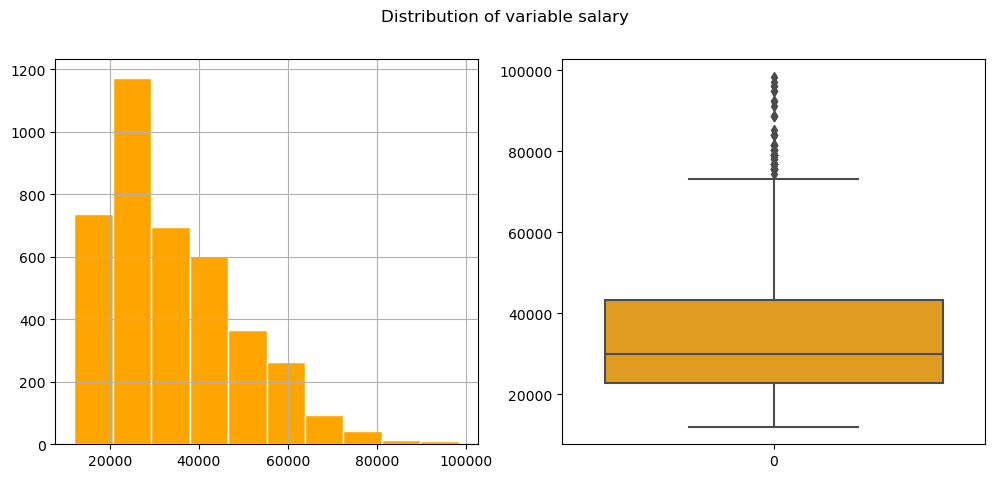

In [266]:
# визуализация непрерывных количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

train_job_satisf['salary'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = train_job_satisf['salary'], color='orange')

plt.suptitle('Distribution of variable salary')

In [267]:
train_job_satisf['salary_l'] = np.log(train_job_satisf['salary'])

Text(0.5, 0.98, 'Distribution of variable log(salary)')

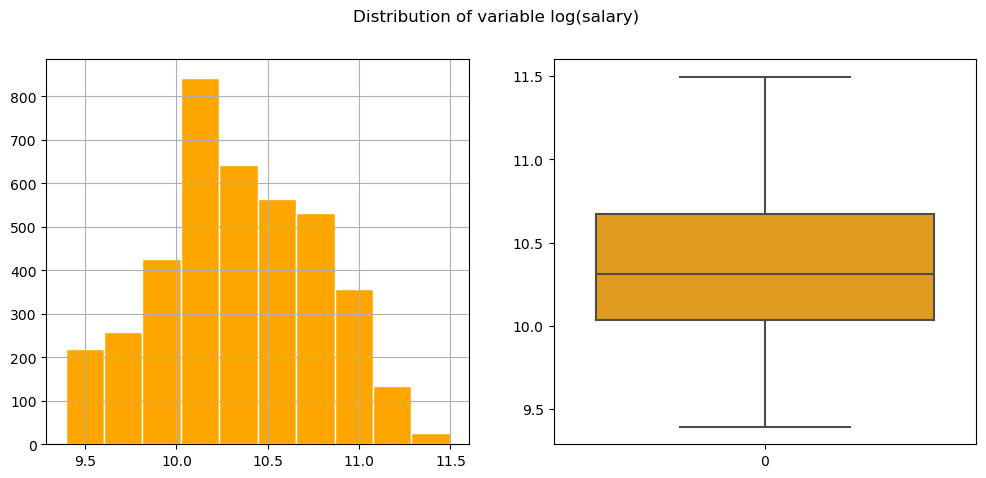

In [268]:
# визуализация непрерывных количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

train_job_satisf['salary_l'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = train_job_satisf['salary_l'], color='orange')

plt.suptitle('Distribution of variable log(salary)')

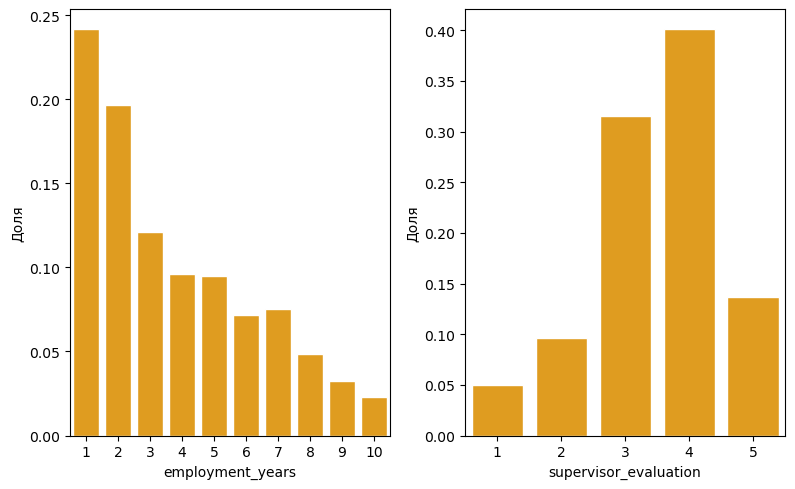

In [269]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_job_satisf[['employment_years', 'supervisor_evaluation']].columns):
    data = pd.DataFrame(train_job_satisf[column].value_counts(normalize=True)).reset_index()
    data.columns=[f'{column}', 'proportion']
    sns.barplot(data = data, x = f'{column}', y= 'proportion', ax=axes[i],
                    edgecolor='white', 
                    color='orange'
                   )

 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Доля') 
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

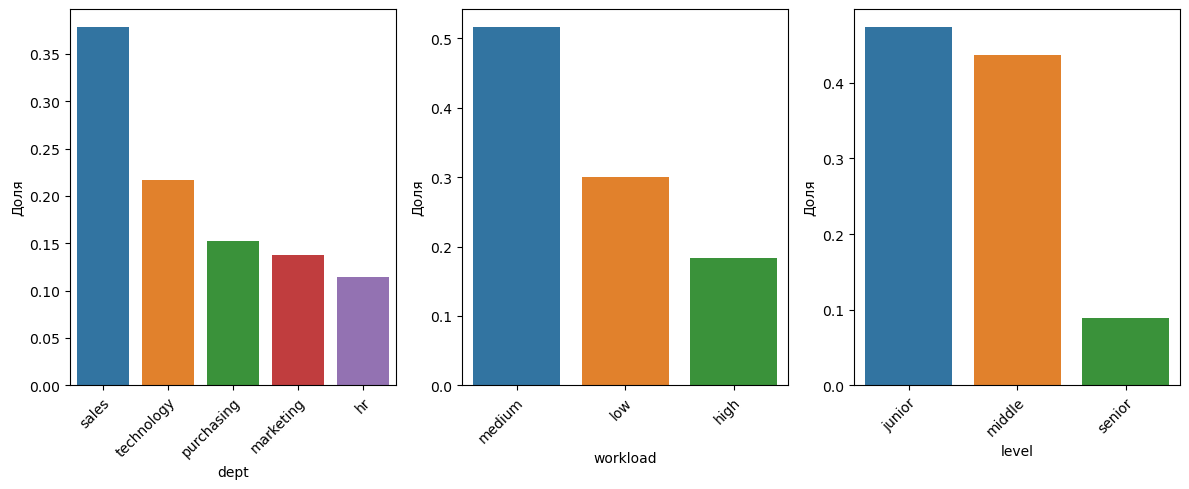

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_job_satisf[['dept', 'workload', 'level']].columns):
    df = pd.DataFrame(train_job_satisf[column].value_counts(normalize=True)).reset_index()
    sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Доля') 
    axes[i].set_xticklabels(
        axes[i].get_xticklabels(), 
        rotation=45,          
        ha='right',           
        rotation_mode='anchor' 
    )

plt.tight_layout()

plt.show()

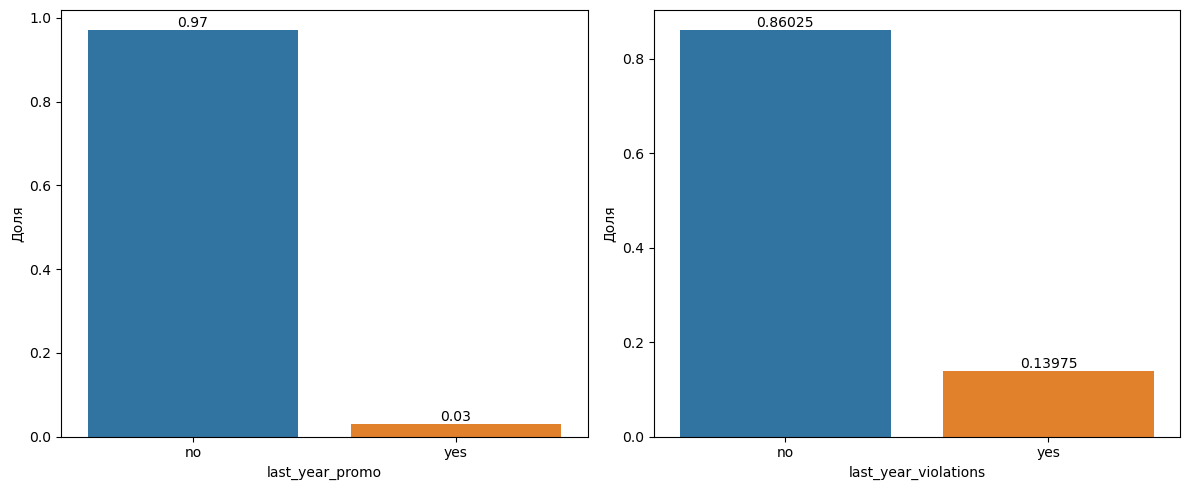

In [271]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_job_satisf[['last_year_promo', 'last_year_violations']].columns):
    df = pd.DataFrame(train_job_satisf[column].value_counts(normalize=True)).reset_index()
    ax = sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])
    ax.bar_label(ax.containers[0], fontsize=10)

    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Доля') 

plt.tight_layout()

plt.show()

Text(0.5, 0.98, "Distribution of employee's satisfaction level")

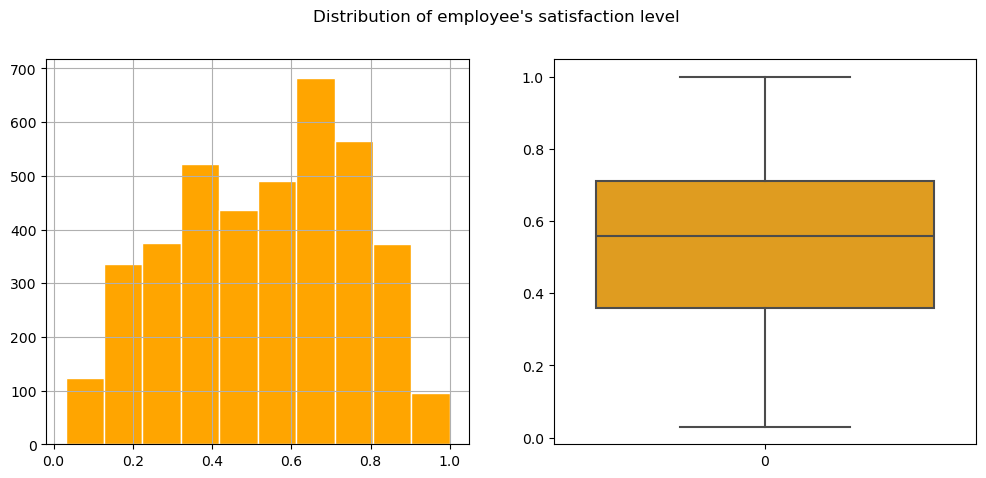

In [272]:
# визуализация непрерывных количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

train_job_satisf['job_satisfaction_rate'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = train_job_satisf['job_satisfaction_rate'], color='orange')

plt.suptitle("Distribution of employee's satisfaction level")

In [273]:
pd.DataFrame(train_job_satisf.groupby(['last_year_promo', 'last_year_violations'])["job_satisfaction_rate"].mean()).reset_index().sort_values(by='job_satisfaction_rate', ascending=True)

last_year_promo last_year_violations  job_satisfaction_rate
1              no                  yes               0.318773
3             yes                  yes               0.371538
0              no                   no               0.564238
2             yes                   no               0.709626

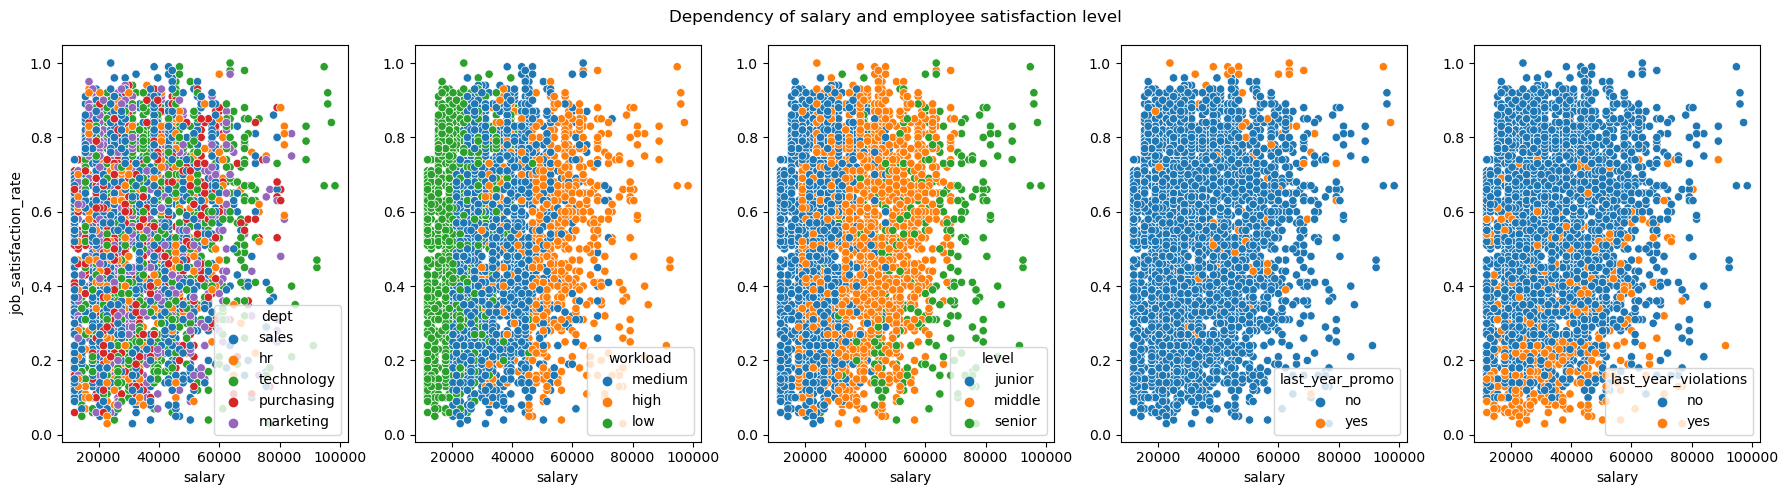

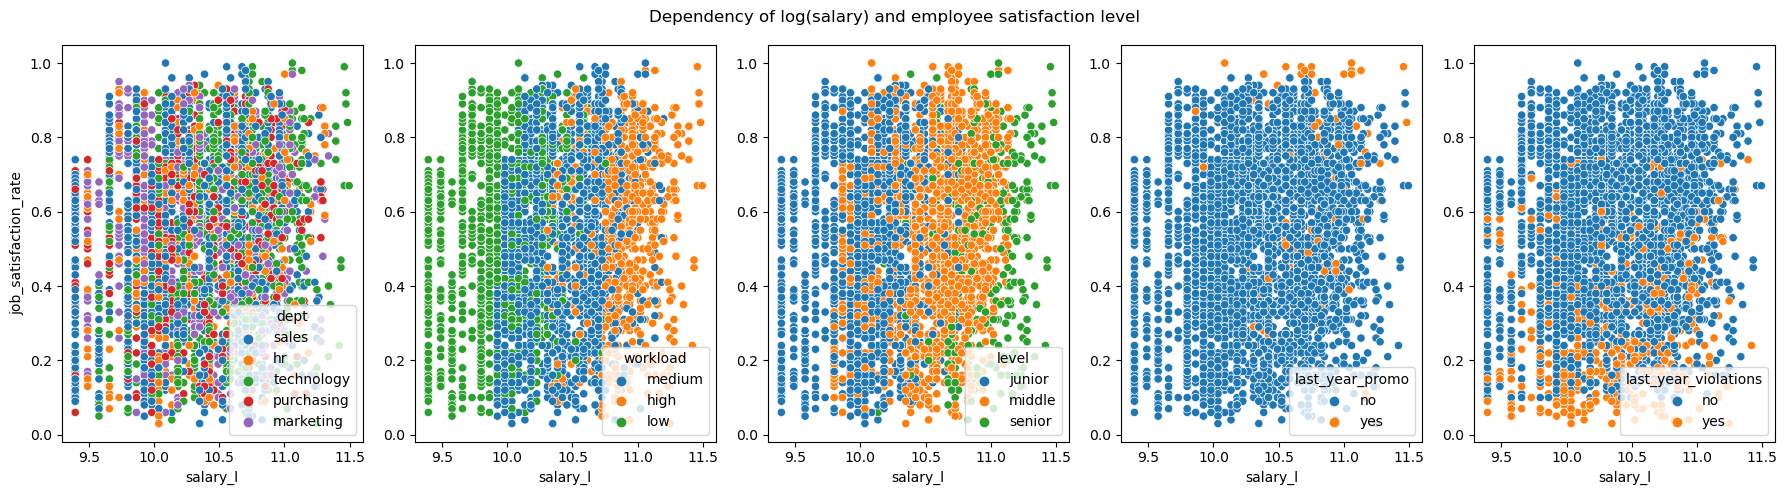

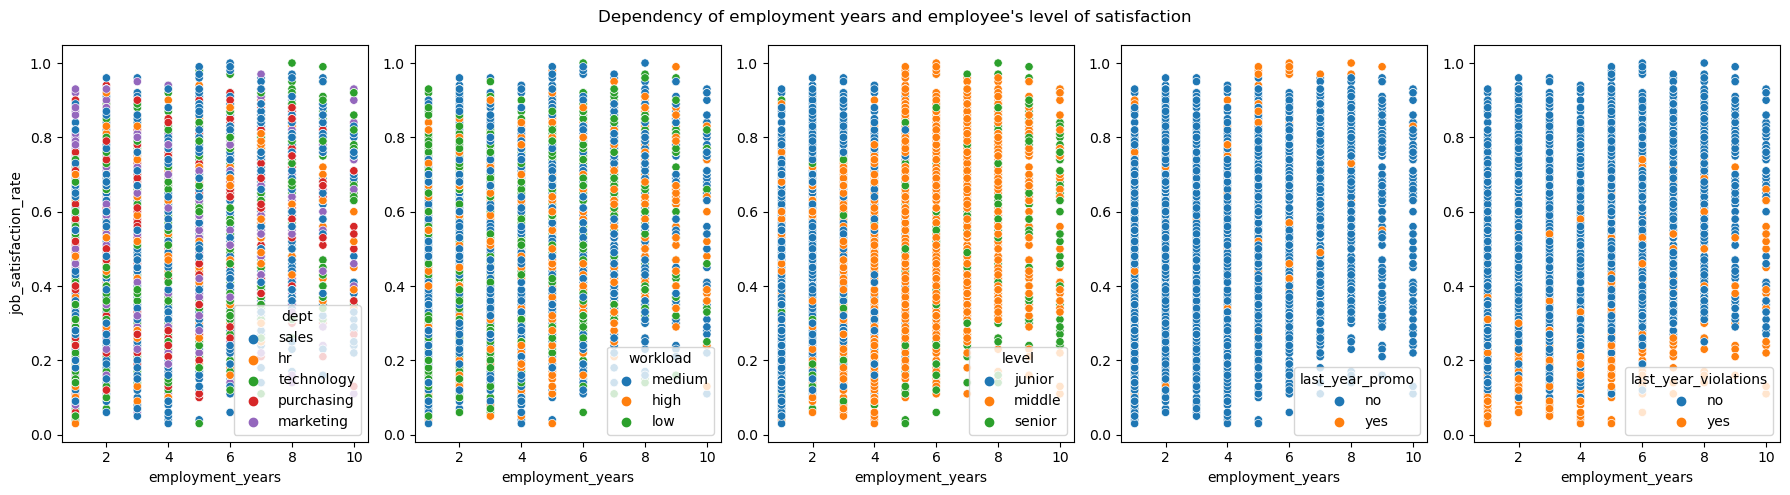

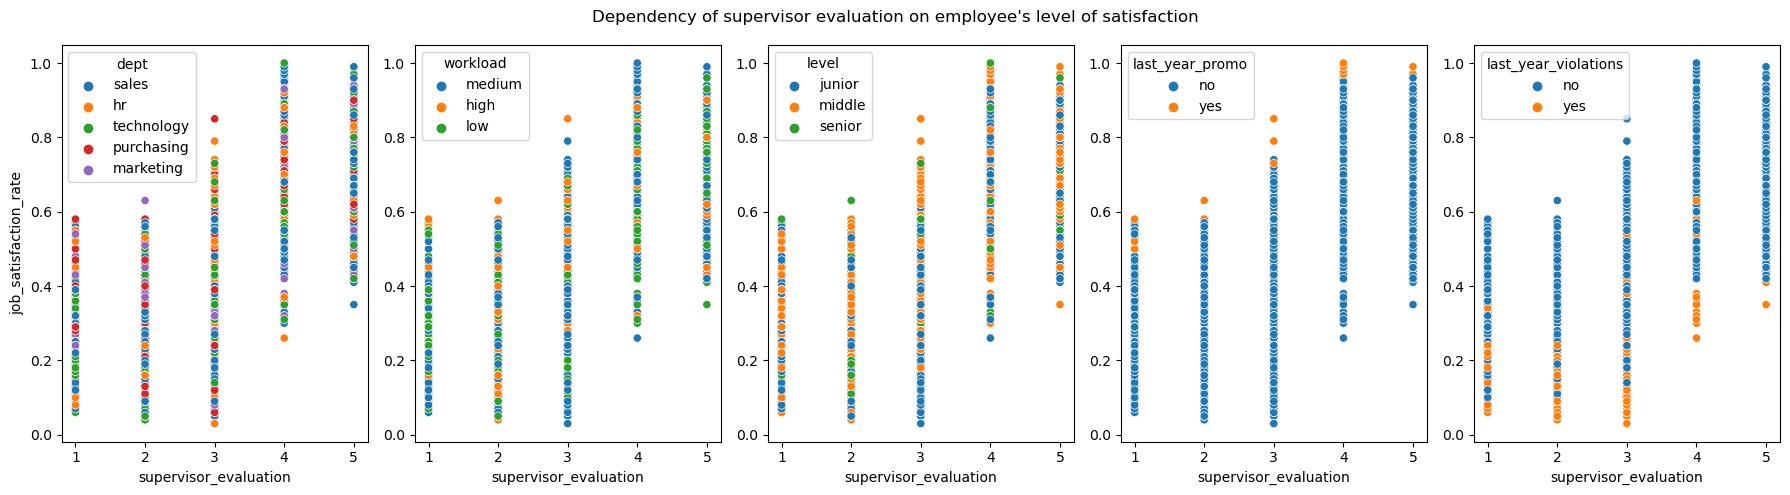

In [274]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Plot on the first subplot
sns.scatterplot(data=train_job_satisf, x="salary", y="job_satisfaction_rate", hue='dept', ax=axes[0])
sns.scatterplot(data=train_job_satisf, x="salary", y="job_satisfaction_rate", hue='workload', ax=axes[1])
axes[1].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary", y="job_satisfaction_rate", hue='level', ax=axes[2])
axes[2].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary", y="job_satisfaction_rate", hue='last_year_promo', ax=axes[3])
axes[3].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary", y="job_satisfaction_rate", hue='last_year_violations', ax=axes[4])
axes[4].set_ylabel('')


fig.suptitle('Dependency of salary and employee satisfaction level')
plt.tight_layout()


fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Plot on the first subplot
sns.scatterplot(data=train_job_satisf, x="salary_l", y="job_satisfaction_rate", hue='dept', ax=axes[0])

sns.scatterplot(data=train_job_satisf, x="salary_l", y="job_satisfaction_rate", hue='workload', ax=axes[1])
axes[1].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary_l", y="job_satisfaction_rate", hue='level', ax=axes[2])
axes[2].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary_l", y="job_satisfaction_rate", hue='last_year_promo', ax=axes[3])
axes[3].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="salary_l", y="job_satisfaction_rate", hue='last_year_violations', ax=axes[4])
axes[4].set_ylabel('')


fig.suptitle('Dependency of log(salary) and employee satisfaction level')
plt.tight_layout()


fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Plot on the first subplot
sns.scatterplot(data=train_job_satisf, x="employment_years", y="job_satisfaction_rate", hue='dept', ax=axes[0])

sns.scatterplot(data=train_job_satisf, x="employment_years", y="job_satisfaction_rate", hue='workload', ax=axes[1])
axes[1].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="employment_years", y="job_satisfaction_rate", hue='level', ax=axes[2])
axes[2].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="employment_years", y="job_satisfaction_rate", hue='last_year_promo', ax=axes[3])
axes[3].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="employment_years", y="job_satisfaction_rate", hue='last_year_violations', ax=axes[4])
axes[4].set_ylabel('')


fig.suptitle("Dependency of employment years and employee's level of satisfaction")
plt.tight_layout()

fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Plot on the first subplot
sns.scatterplot(data=train_job_satisf, x="supervisor_evaluation", y="job_satisfaction_rate", hue='dept', ax=axes[0])

sns.scatterplot(data=train_job_satisf, x="supervisor_evaluation", y="job_satisfaction_rate", hue='workload', ax=axes[1])
axes[1].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="supervisor_evaluation", y="job_satisfaction_rate", hue='level', ax=axes[2])
axes[2].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="supervisor_evaluation", y="job_satisfaction_rate", hue='last_year_promo', ax=axes[3])
axes[3].set_ylabel('')

sns.scatterplot(data=train_job_satisf, x="supervisor_evaluation", y="job_satisfaction_rate", hue='last_year_violations', ax=axes[4])
axes[4].set_ylabel('')


fig.suptitle("Dependency of supervisor evaluation on employee's level of satisfaction")
plt.tight_layout()


In [275]:
train_job_satisf['supervisor_evaluation_class'] = train_job_satisf['supervisor_evaluation'].apply(lambda x: 1 if x<=2 else 2 if x==3 else 3)

In [276]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'salary_l']
ohe_columns = ['dept','last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'level']

Text(0.5, 1.0, 'Matrix of correlation coefficients phik in market_file (non-linear relations)')

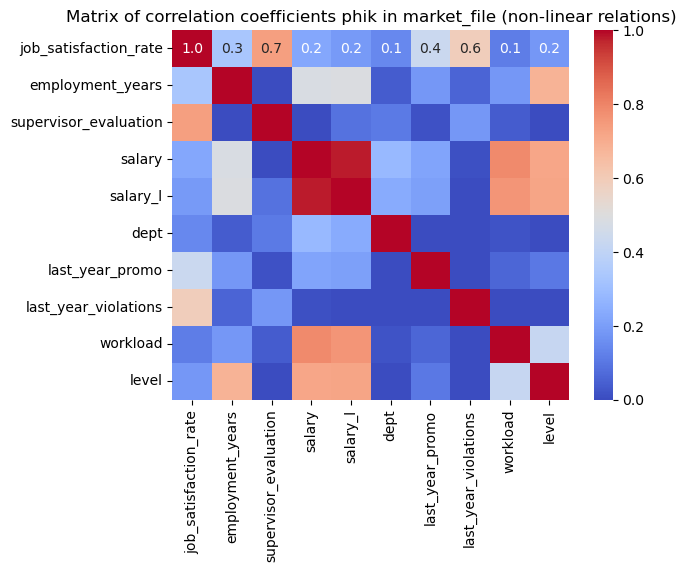

In [277]:
sns.heatmap(train_job_satisf[["job_satisfaction_rate", 'employment_years', 'supervisor_evaluation', 'salary', 'salary_l', 'dept', 'last_year_promo', 'last_year_violations', 'workload', 'level']].phik_matrix(interval_cols=num_columns), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Matrix of correlation coefficients phik in market_file (non-linear relations)')

In [278]:
X = add_constant(train_job_satisf[num_columns])

In [279]:
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

const                    7127.454572
employment_years            1.281279
supervisor_evaluation       1.000032
salary                     15.332586
salary_l                   15.356390
dtype: float64

## Analysis of test data

In [280]:
test_features.describe()

id  employment_years  supervisor_evaluation        salary
count    2000.000000       2000.000000            2000.000000   2000.000000
mean   552765.213500          3.666500               3.526500  34066.800000
std    253851.326129          2.537222               0.996892  15398.436729
min    100298.000000          1.000000               1.000000  12000.000000
25%    339052.000000          1.000000               3.000000  22800.000000
50%    550793.000000          3.000000               4.000000  30000.000000
75%    765763.750000          6.000000               4.000000  43200.000000
max    999029.000000         10.000000               5.000000  96000.000000

Text(0.5, 0.98, 'Distribution of salary variable')

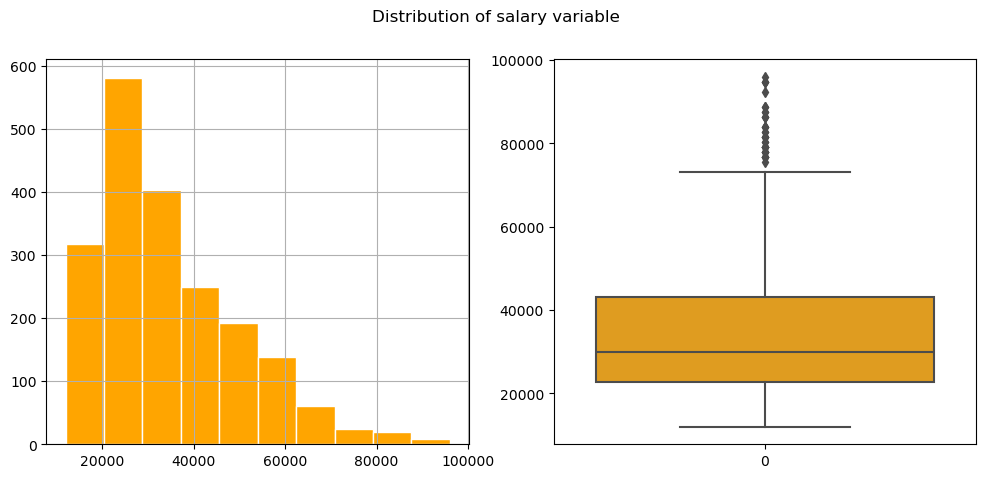

In [281]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

test_features['salary'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = test_features['salary'], color='orange')

plt.suptitle('Distribution of salary variable')

In [282]:
test_features['salary_l'] = np.log(test_features['salary'])

Text(0.5, 0.98, 'Distribution of log(salary) variable')

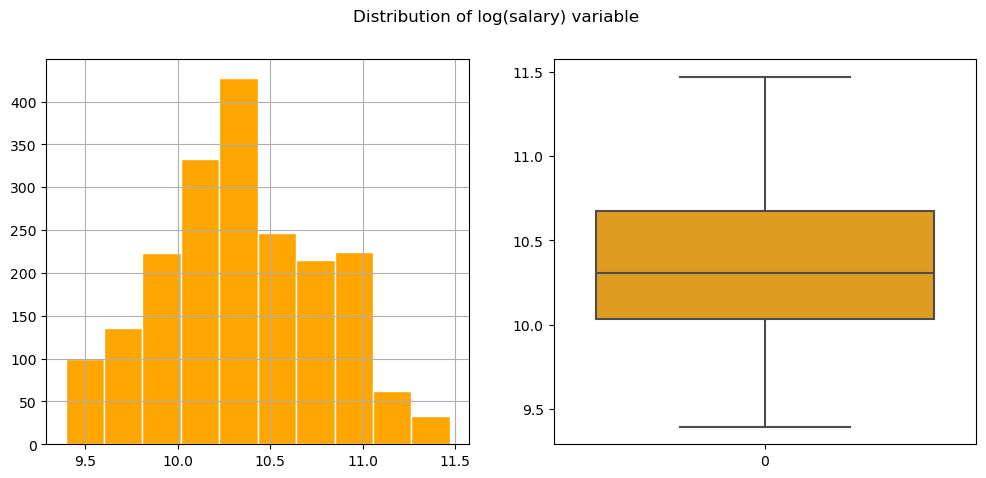

In [283]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

test_features['salary_l'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = test_features['salary_l'], color='orange')

plt.suptitle('Distribution of log(salary) variable')

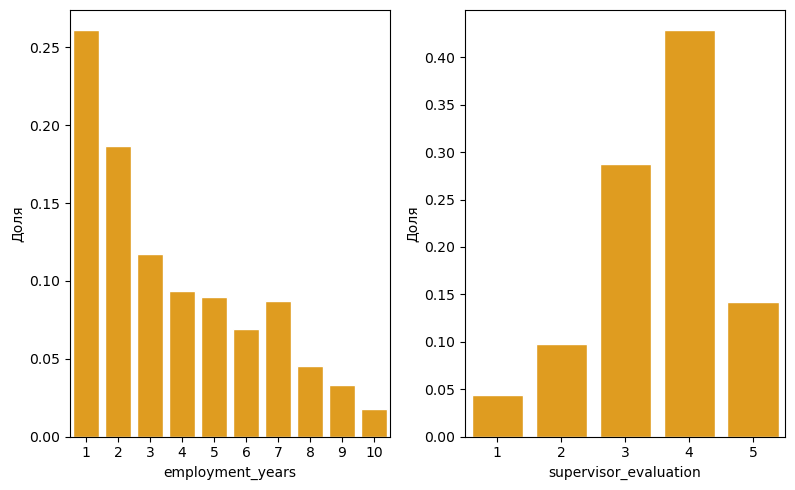

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(test_features[['employment_years', 'supervisor_evaluation']].columns):
    data = pd.DataFrame(test_features[column].value_counts(normalize=True)).reset_index()
    data.columns=[f'{column}', 'proportion']
    sns.barplot(data = data, x = f'{column}', y= 'proportion', ax=axes[i],
                    edgecolor='white', 
                    color='orange'
                   )

 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Доля') 
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

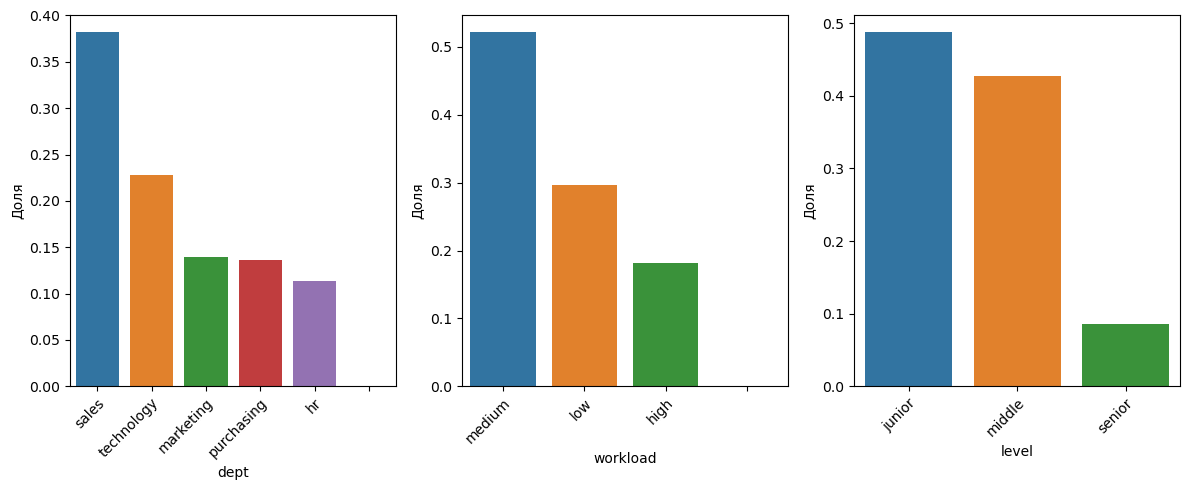

In [285]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(test_features[['dept', 'workload', 'level']].columns):
    df = pd.DataFrame(test_features[column].value_counts(normalize=True)).reset_index()
    sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Доля') 
    axes[i].set_xticklabels(
        axes[i].get_xticklabels(), 
        rotation=45,          
        ha='right',           
        rotation_mode='anchor' 
    )

plt.tight_layout()

plt.show()

Text(0.5, 0.98, 'Distribution of level of satisfaction variable')

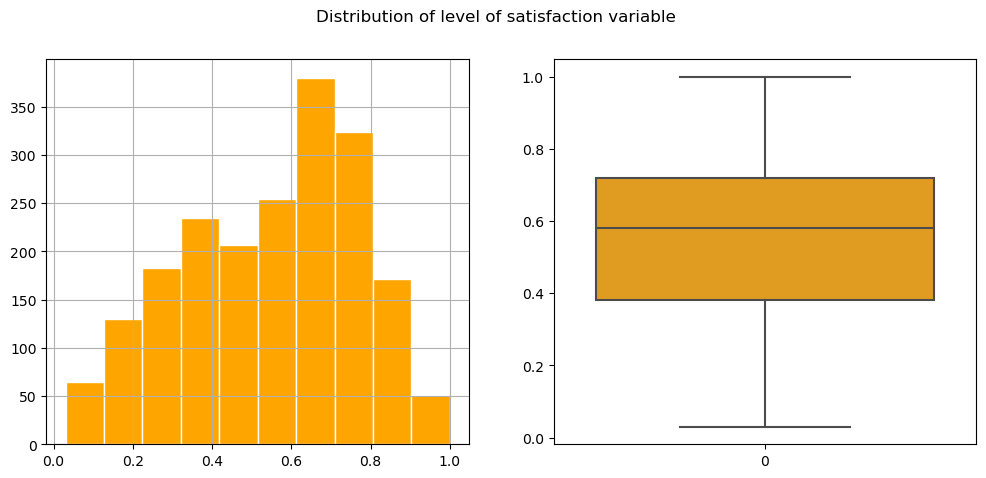

In [286]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

test_target['job_satisfaction_rate'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = test_target['job_satisfaction_rate'], color='orange')

plt.suptitle('Distribution of level of satisfaction variable')

#### Summary: Exploratory Data Analysis
**General Insights**
- Average salary is ~34,000 RUB/month, with a left-skewed distribution.
- Most employees have <5 years of experience.
- Average manager rating is 4 out of 5.
- The largest departments are Sales (37%), Technical (22%), Marketing & Procurement (~15%), and HR (12%).
- Workload: ~50% medium, 30% low, 20% high.
- Seniority: Mostly Junior and Middle, few Senior staff.
- Only 3% received promotions, and 14% violated contract terms.
- Average satisfaction: 0.5 out of 1, not normally distributed.

**Key Relationships**
Manager rating and contract violations show the strongest correlation with satisfaction:
- Higher ratings → Higher satisfaction.
- No violations → Higher satisfaction.
- Other variables have a weaker but positive effect.

## Predicting model

To prepare the data for modeling, numerical and categorical features were processed as follows:nal encoding

- **Numerical Features (Scaled):**
  - Applied standard scaling to quantitative features for better model performance
  - This helps algorithms sensitive to feature magnitude (e.g., logistic regression, gradient boosting)

- **Categorical Features (Encoded):**
  - `OneHotEncoder` applied to nominal (unordered) categorical variables:  
    `['dept', 'last_year_promo', 'last_year_violations']`

  - `OrdinalEncoder` applied to ordinal (ordered) categorical variables:  
    `['workload', 'level']`  
    These features have a natural order, which is preserved by ordinal encoding

In [287]:
train_job_satisf.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  \
0                   no                      1   24000                   0.58   
1                   no                      5   38400                   0.76   
2                   no                      2   12000                   0.11   
3                   no                      2   18000                   0.37   
4                   no                      3   22800                   0.20   

    salary_l  supervisor_evaluation_class  
0  10.085809                            1  
1  10.555813                            3  
2   9.392662                            1  
3   9.798127                            1  
4  10.034516                            2

In [288]:
train_job_satisf = train_job_satisf.drop(columns=['id'])

In [289]:
train_job_satisf.duplicated().sum()

245

In [290]:
train_job_satisf = train_job_satisf.drop_duplicates()

In [291]:
train_job_satisf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3755 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   dept                         3749 non-null   object 
 1   level                        3751 non-null   object 
 2   workload                     3755 non-null   object 
 3   employment_years             3755 non-null   int64  
 4   last_year_promo              3755 non-null   object 
 5   last_year_violations         3755 non-null   object 
 6   supervisor_evaluation        3755 non-null   int64  
 7   salary                       3755 non-null   int64  
 8   job_satisfaction_rate        3755 non-null   float64
 9   salary_l                     3755 non-null   float64
 10  supervisor_evaluation_class  3755 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 352.0+ KB


In [292]:
X = train_job_satisf.drop(columns=['job_satisfaction_rate', 'salary', 'supervisor_evaluation'])
y = train_job_satisf['job_satisfaction_rate']

In [293]:
num_columns = ['employment_years', 'salary_l']
ohe_columns = ['dept','last_year_promo', 'last_year_violations', 'supervisor_evaluation_class']
ord_columns = ['workload', 'level']

In [294]:
def replace_space_with_nan(X):
    X = X.copy()
    X.loc[X['dept'] == ' ', 'dept'] = np.nan
    return X

In [295]:
ohe_pipe = Pipeline([
    ('handle_space_dept', FunctionTransformer(
        replace_space_with_nan,
        feature_names_out='one-to-one'
    )),
    ('imputer_nan', SimpleImputer(
        missing_values=np.nan,
        strategy='most_frequent'
    )),
    
    ('ohe', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False
    ))
])

In [296]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
         SimpleImputer(missing_values=np.nan,
                      strategy='most_frequent')
        ),
        ('ord',
         OrdinalEncoder(categories=[
             ['low', 'medium', 'high'],
             ['junior', 'middle', 'senior']
         ],
                       handle_unknown = 'use_encoded_value',
                       unknown_value = np.nan)
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values = np.nan, 
                          strategy = 'most_frequent')
        )]
)

In [297]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

In [298]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', 'passthrough')
    ]
)

In [299]:
param_grid = [
    {
        'models':[LinearRegression()],
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth':range(2,11),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    }
]

In [300]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    mask = (y_true == 0) & (y_pred == 0)
    smape_values = np.where(
        mask,
        0, 
        numerator / denominator
    )
    return np.mean(smape_values)*100

In [301]:
smape_scorer = make_scorer(
    smape,
    greater_is_better=False  # SMAPE is a loss (lower = better)
)

In [302]:
grid_1 = GridSearchCV(
    pipe_final, 
    param_grid = param_grid,
    cv = 5, 
    scoring = smape_scorer,
    n_jobs=-1
)

In [303]:
grid_1.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('handle_space_dept',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function replace_space_with_nan at 0x000002981E22BA60>)),
                                                                                         ('imputer_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(dr...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(max_depth=10,
                                                           random_state=42)],
                          'models__max_depth': range(2, 11),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False))

In [304]:
grid_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('handle_space_dept',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function replace_space_with_nan at 0x000002981E22BA60>)),
                                                                  ('imputer_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='i...
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'salary_l'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=10, random_state=42))])

In [305]:
grid_1.cv_results_

{'mean_fit_time': array([0.39085522, 0.30298948, 0.2591331 , 0.10675898, 0.11342859,
        0.10536265, 0.10939579, 0.09411421, 0.07875295, 0.06333013,
        0.0993156 , 0.07228279, 0.08135939, 0.12063036, 0.13709049,
        0.10302076, 0.12109585, 0.09141278, 0.11027217, 0.10825276,
        0.12931781, 0.12383499, 0.11331992, 0.11154776, 0.09384918,
        0.09805565, 0.10364847, 0.0882431 , 0.06227574, 0.06015453,
        0.08265662, 0.08128686, 0.04981656, 0.08661036, 0.08789587,
        0.10094018, 0.11506   , 0.10294514, 0.100453  , 0.07940516]),
 'std_fit_time': array([0.24885823, 0.07864458, 0.02986176, 0.09065312, 0.04832997,
        0.0110349 , 0.03173944, 0.02716155, 0.01954558, 0.01466854,
        0.04341949, 0.00660885, 0.01124782, 0.01908219, 0.00481512,
        0.03482944, 0.00860764, 0.03846561, 0.00600458, 0.00717075,
        0.0098389 , 0.00883828, 0.03348266, 0.00915751, 0.00429072,
        0.00807731, 0.00540118, 0.0079659 , 0.01459676, 0.01743182,
        0.014

In [306]:
results = pd.DataFrame(grid_1.cv_results_)

In [307]:
pd.set_option('display.max_colwidth', None)

In [308]:
results.sort_values(by='rank_test_score')[['rank_test_score', 'mean_test_score','params']].head(10)

rank_test_score  mean_test_score  \
37                1       -16.319711   
39                2       -16.324366   
36                2       -16.324366   
38                2       -16.324366   
33                5       -16.802656   
32                6       -16.804701   
35                7       -16.807311   
34                7       -16.807311   
31                9       -17.213007   
30                9       -17.213007   

                                                                                                                              params  
37    {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 10, 'preprocessor__num': MinMaxScaler()}  
39     {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 10, 'preprocessor__num': 'passthrough'}  
36  {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 10, 'preprocessor__num': StandardScaler()}  
38    {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 10, 'preprocessor__num': RobustScaler()}  
33     {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 9, 'preprocessor__num': MinMaxScaler()}  
32   {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 9, 'preprocessor__num': StandardScaler()}  
35      {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 9, 'preprocessor__num': 'passthrough'}  
34     {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 9, 'preprocessor__num': RobustScaler()}  
31      {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 8, 'preprocessor__num': 'passthrough'}  
30     {'models': DecisionTreeRegressor(max_depth=10, random_state=42), 'models__max_depth': 8, 'preprocessor__num': RobustScaler()}

In [309]:
y_pred = grid_1.predict(X)

In [310]:
model = grid_1.best_estimator_

In [311]:
y_true = np.array(test_target['job_satisfaction_rate'])
y_true

array([0.74, 0.75, 0.6 , ..., 0.39, 0.26, 0.62])

In [312]:
model = grid_1.best_estimator_

In [313]:
y_pred 

array([0.50741935, 0.79928571, 0.15833333, ..., 0.81352941, 0.50741935,
       0.26166667])

In [314]:
residuals = y - y_pred

In [315]:
smape_1 = -grid_1.best_score_
r_2_1 = r2_score(y, y_pred)
mse_1 = mean_squared_error(y, y_pred)
rmse_1 = mean_squared_error(y, y_pred, squared=False)
mae_1 = mean_absolute_error(y, y_pred)

In [316]:
print(f'SMAPE: {smape_1}')
print(f'R-squared: {r_2_1}')
print(f'MSE: {mse_1}')
print(f'RMSE: {rmse_1}')
print(f'MAE: {mae_1}')

SMAPE: 16.31971090471948
R-squared: 0.91651833768419
MSE: 0.004277613890410208
RMSE: 0.06540347001811302
MAE: 0.048639596691619935


Text(0.5, 1.0, 'Residual analysis model 1')

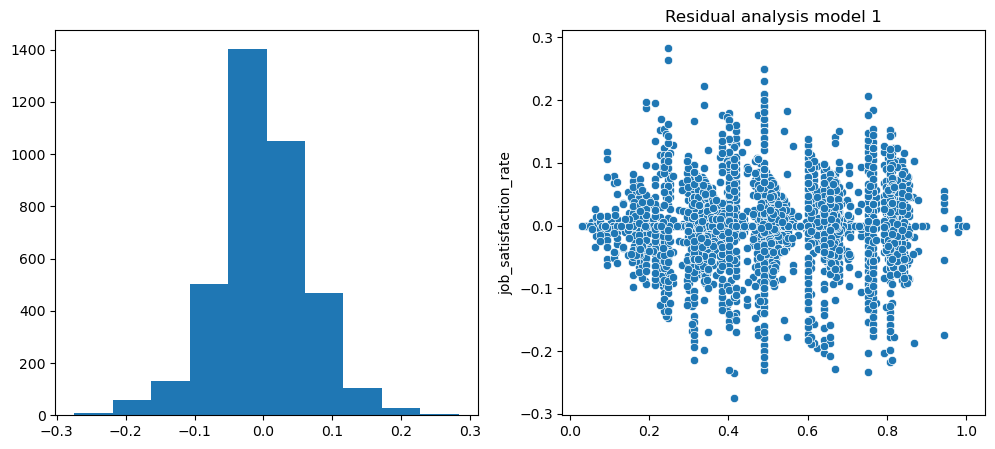

In [317]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(residuals)

sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
plt.title('Residual analysis model 1')

***

### Advanced hyperparameter selection

In [318]:
X.head()

dept   level workload  employment_years last_year_promo  \
0       sales  junior   medium                 2              no   
1          hr  junior     high                 2              no   
2       sales  junior      low                 1              no   
3  technology  junior      low                 4              no   
4          hr  junior   medium                 1              no   

  last_year_violations   salary_l  supervisor_evaluation_class  
0                   no  10.085809                            1  
1                   no  10.555813                            3  
2                   no   9.392662                            1  
3                   no   9.798127                            1  
4                   no  10.034516                            2

In [319]:
num_columns = ['employment_years', 'salary_l']
ohe_columns = ['dept','last_year_promo', 'last_year_violations', 'supervisor_evaluation_class']
ord_columns = ['workload', 'level']

In [320]:
param_grid = [
    {
        'models':[LinearRegression()],
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth':range(2,20),
        'models__min_samples_split':range(2,7),
        'models__min_samples_leaf':range(1,5),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    }
]

In [321]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    mask = (y_true == 0) & (y_pred == 0)
    smape_values = np.where(
        mask,
        0, 
        numerator / denominator
    )
    return np.mean(smape_values)*100

In [322]:
smape_scorer = make_scorer(
    smape,
    greater_is_better=False  # SMAPE is a loss (lower = better)
)

In [323]:
grid_2 = GridSearchCV(
    pipe_final, 
    param_grid = param_grid,
    cv = 5, 
    scoring = smape_scorer,
    n_jobs=-1
)

In [324]:
grid_2.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('handle_space_dept',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<function replace_space_with_nan at 0x000002981E22BA60>)),
                                                                                         ('imputer_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(dr...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(max_depth=19,
                                                           min_samples_split=6,
                                                           random_state=42)],
                          'models__max_depth': range(2, 20),
                          'models__min_samples_leaf': range(1, 5),
                          'models__min_samples_split': range(2, 7),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False))

In [325]:
grid_2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('handle_space_dept',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function replace_space_with_nan at 0x000002981E22BA60>)),
                                                                  ('imputer_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='i...
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'salary_l'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=19, min_samples_split=6,
                                       random_state=42))])

In [326]:
y_pred = grid_2.predict(X)

In [327]:
smape_2 = -grid_2.best_score_
r_2_2 = r2_score(y, y_pred)
mse_2 = mean_squared_error(y, y_pred)
rmse_2 = mean_squared_error(y, y_pred, squared=False)
mae_2 = mean_absolute_error(y, y_pred)

In [328]:
print(f'SMAPE: {smape_2}')
print(f'R-squared: {r_2_2}')
print(f'MSE: {mse_2}')
print(f'RMSE: {rmse_2}')
print(f'MAE: {mae_2}')

SMAPE: 14.970357505774341
R-squared: 0.9643304240843289
MSE: 0.0018277148438264842
RMSE: 0.04275178176200945
MAE: 0.032363273339053


In [329]:
residuals = y - y_pred

Text(0.5, 1.0, 'Residual analysis model 2')

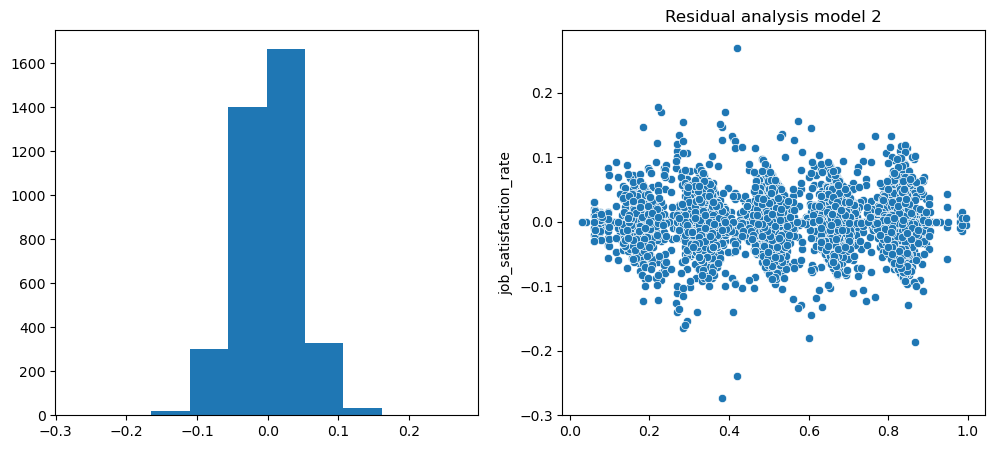

In [330]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(residuals)

sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
plt.title('Residual analysis model 2')

In [331]:
print('Results for model 1')
print(f'SMAPE: {smape_1}')
print(f'R-squared: {r_2_1}')
print(f'MSE: {mse_1}')
print(f'RMSE: {rmse_1}')
print(f'MAE: {mae_1}')
print('')
print('Results for model 2 (model 1 with advanced hyperparameter selection)')
print(f'SMAPE: {smape_2}')
print(f'R-squared: {r_2_2}')
print(f'MSE: {mse_2}')
print(f'RMSE: {rmse_2}')
print(f'MAE: {mae_2}')

Results for model 1
SMAPE: 16.31971090471948
R-squared: 0.91651833768419
MSE: 0.004277613890410208
RMSE: 0.06540347001811302
MAE: 0.048639596691619935

Results for model 2 (model 1 with advanced hyperparameter selection)
SMAPE: 14.970357505774341
R-squared: 0.9643304240843289
MSE: 0.0018277148438264842
RMSE: 0.04275178176200945
MAE: 0.032363273339053


***

### Testing the best model

In [332]:
X_test = test_features.sort_values(by='id', ascending = True)
X_test.head()

id        dept   level workload  employment_years last_year_promo  \
1172  100298          hr  junior      low                 2              no   
852   100480   marketing  junior      low                 4              no   
848   100503  purchasing  middle     high                 5              no   
524   100610       sales  middle   medium                 5              no   
476   100692       sales  middle     high                 6              no   

     last_year_violations  supervisor_evaluation  salary   salary_l  
1172                   no                      4   19200   9.862666  
852                    no                      4   16800   9.729134  
848                    no                      4   55200  10.918718  
524                    no                      4   43200  10.673596  
476                    no                      4   48000  10.778956

In [333]:
y_test = test_target.sort_values(by='id', ascending=True)
y_test.head(5)

id  job_satisfaction_rate
1734  100298                   0.80
1467  100480                   0.84
190   100503                   0.79
60    100610                   0.75
231   100692                   0.69

In [334]:
X_test['salary_l'] = np.log(X_test['salary'])

In [335]:
X_test['supervisor_evaluation_class'] = X_test['supervisor_evaluation'].apply(lambda x: 1 if x<=2 else 2 if x==3 else 3)

In [336]:
X_test = X_test.drop(columns=['id', 'salary', 'supervisor_evaluation'])

In [337]:
X_test.head(5)

dept   level workload  employment_years last_year_promo  \
1172          hr  junior      low                 2              no   
852    marketing  junior      low                 4              no   
848   purchasing  middle     high                 5              no   
524        sales  middle   medium                 5              no   
476        sales  middle     high                 6              no   

     last_year_violations   salary_l  supervisor_evaluation_class  
1172                   no   9.862666                            3  
852                    no   9.729134                            3  
848                    no  10.918718                            3  
524                    no  10.673596                            3  
476                    no  10.778956                            3

In [338]:
num_columns = ['employment_years', 'salary_l']
ohe_columns = ['dept','last_year_promo', 'last_year_violations', 'supervisor_evaluation_class']
ord_columns = ['workload', 'level']

In [339]:
y_pred = grid_2.predict(X_test)

In [340]:
y_pred

array([0.8175    , 0.842     , 0.74666667, ..., 0.508     , 0.42666667,
       0.335     ])

In [341]:
y_test = y_test['job_satisfaction_rate']
y_test

1734    0.80
1467    0.84
190     0.79
60      0.75
231     0.69
        ... 
1026    0.79
1613    0.76
780     0.48
931     0.57
334     0.35
Name: job_satisfaction_rate, Length: 2000, dtype: float64

In [342]:
smape_test = smape(y_test, y_pred)
r_2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_pred)

In [343]:
print(f'SMAPE: {smape_test}')
print(f'R-squared: {r_2_test}')
print(f'MSE: {mse_test}')
print(f'RMSE: {rmse_test}')
print(f'MAE: {mae_test}')

SMAPE: 13.774362728383213
R-squared: 0.8778214187354079
MSE: 0.005916377036428152
RMSE: 0.07691798903005818
MAE: 0.05826187855565487


In [344]:
residuals = y_test - y_pred

In [345]:
y_test

1734    0.80
1467    0.84
190     0.79
60      0.75
231     0.69
        ... 
1026    0.79
1613    0.76
780     0.48
931     0.57
334     0.35
Name: job_satisfaction_rate, Length: 2000, dtype: float64

Text(0.5, 1.0, 'Residuals analysis model 2')

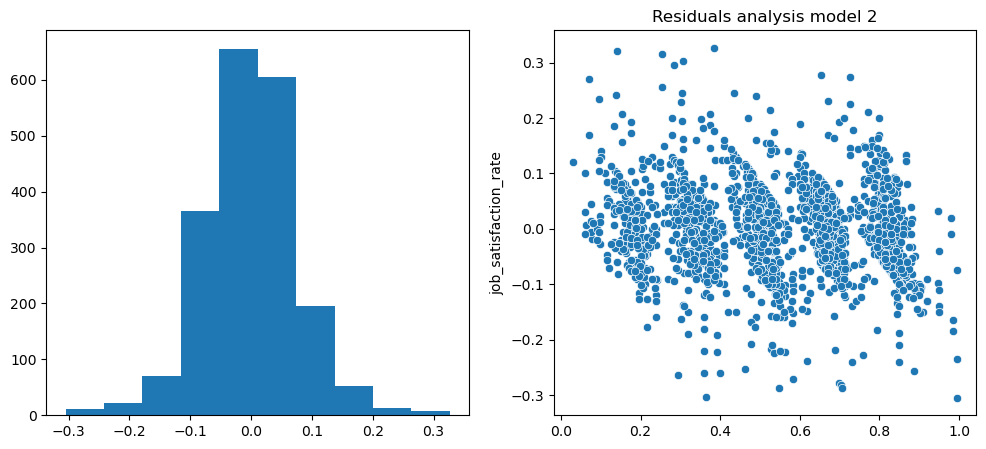

In [346]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(residuals)

sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
plt.title('Residuals analysis model 2')

In [347]:
best_pipe = grid_2.best_estimator_

In [348]:
best_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('handle_space_dept',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function replace_space_with_nan at 0x000002981E22BA60>)),
                                                                  ('imputer_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='i...
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', RobustScaler(),
                                                  ['employment_years',
                                                   'salary_l'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=19, min_samples_split=6,
                                       random_state=42))])

In [349]:
def predict_wrapper(X):
    if isinstance(X, pd.DataFrame):
        # Ensure DataFrame has correct original columns
        return best_pipe.predict_proba(X[num_columns + ohe_columns])
    else:
        # For numpy arrays, use the preprocessor's input shape
        if X.shape[1] == len(num_columns + ohe_columns):
            # Raw features before encoding
            X_df = pd.DataFrame(X, columns=num_columns + ohe_columns)
            return best_pipe.predict(X_df)
        elif X.shape[1] == len(true_feature_names):
            # Already transformed features
            return best_pipe.named_steps['models'].predict(X)
        else:
            raise ValueError(f"Input has {X.shape[1]} features, expected {len(num_columns + ohe_columns)} or {len(true_feature_names)}")


In [350]:
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            if transformer == 'passthrough':
                feature_names.extend(features)
            else:
                feature_names.extend(features)  # Numerical features keep original names
        elif name == 'ohe':
            if hasattr(transformer, 'get_feature_names_out'):
                # Get one-hot encoded feature names
                ohe_features = transformer.get_feature_names_out(features)
                feature_names.extend(ohe_features)
            else:
                feature_names.extend(features)
    return feature_names

In [351]:
feature_names = get_feature_names(best_pipe.named_steps['preprocessor'])
feature_names

['dept_marketing',
 'dept_purchasing',
 'dept_sales',
 'dept_technology',
 'last_year_promo_yes',
 'last_year_violations_yes',
 'supervisor_evaluation_class_2',
 'supervisor_evaluation_class_3',
 'employment_years',
 'salary_l']

In [352]:
X_test_transformed = best_pipe.named_steps['preprocessor'].transform(X)
true_feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
print(f"Actual number of features: {len(true_feature_names)}")
print(true_feature_names)

Actual number of features: 12
['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_sales'
 'ohe__dept_technology' 'ohe__last_year_promo_yes'
 'ohe__last_year_violations_yes' 'ohe__supervisor_evaluation_class_2'
 'ohe__supervisor_evaluation_class_3' 'ord__workload' 'ord__level'
 'num__employment_years' 'num__salary_l']


In [353]:
background_data = shap.utils.sample(X_test_transformed, 100)

In [354]:
explainer = shap.Explainer(
    model=predict_wrapper,
    masker=background_data,
    feature_names=true_feature_names  # Use actual output feature names
)

In [355]:
X_test_transformed = best_pipe.named_steps['preprocessor'].transform(X_test)

In [356]:
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 2001it [00:50, 31.71it/s]                                                              


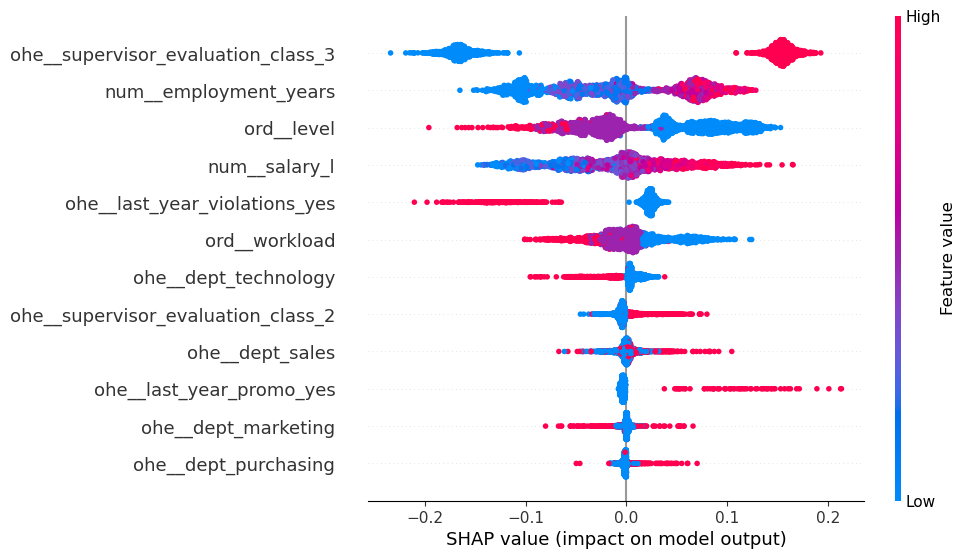

In [357]:
shap.plots.beeswarm(shap_values, max_display=12)

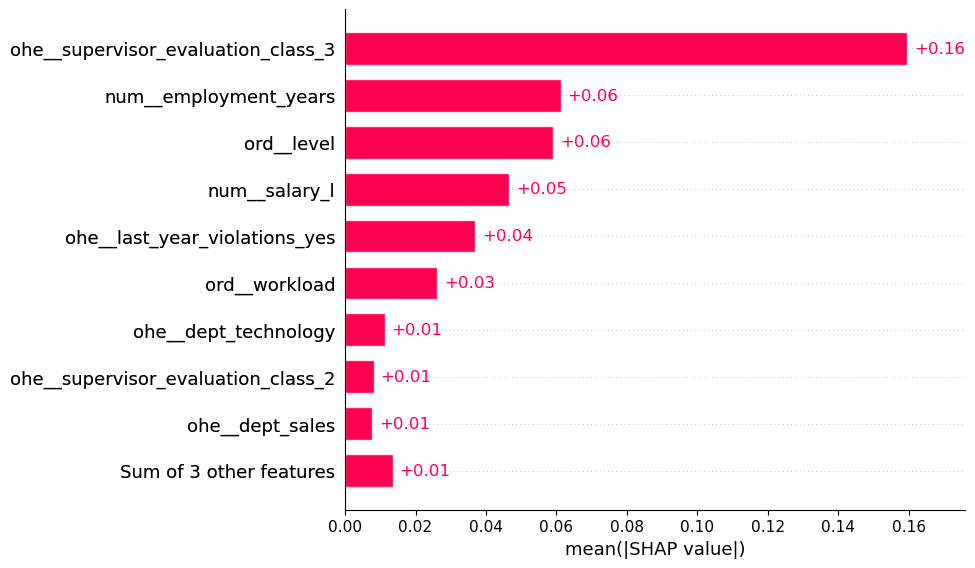

In [358]:
shap.plots.bar(shap_values)

***
#### Model Insights: Employee Job Satisfaction Prediction

Based on the trained regression model, the following factors were identified as significantly influencing employee job satisfaction:**### Key Find**ings

- **Supervisor Evaluation**  
  Employees with a supervisor rating above 3 tend to report 0.16 higher satisfaction on average.  
  This factor had the strongest impact on satisfaction scores.

- **Years of Employment**  
  Longer tenure in the company correlates positively with job satisfaction.

- **Job Level**  
  Employees at higher-level positions tend to report lower satisfaction, possibly due to increased responsibility or pressure.

- **Salary**  
  Higher monthly salary is associated with greater satisfaction.

- **Policy Violations (Last Year)**  
  Employees who violated labor policies in the last year show lower satisfaction.

- **Workload**  
  Heavier workloads have a negative impact on satisfaction levels.

- **Department Effects**  
  Employees in technical departments tend to be less satisfied,  
  while employees in sales departments tend# to be more satisfied.

### Conclusion

The most influential factor in predicting employee satisfaction is the supervisor’s evaluation.  
This highlights the importance of effective management in supporting employee engagement and well-being.

These insights can inform HR policies related to leadership development, workload management, and employee retention strategies.

## Predicting employee departures from a company

### Data loading and preprocessing

In [359]:
train_quit = pd.read_csv('https://code.s3.yandex.net//datasets/train_quit.csv')

In [360]:
train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [361]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [362]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [363]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [364]:
train_quit.loc[train_quit['level']=='sinior', 'level'] = 'senior'

In [365]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [366]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

In [367]:
train_quit.duplicated().sum()

0

In [368]:
test_target_quit = pd.read_csv('https://code.s3.yandex.net//datasets/test_target_quit.csv')

In [369]:
test_target_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [370]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [371]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

In [372]:
test_target_quit.duplicated().sum()

0

#### Data Load and Preprocessing Summary (Attrition Dataset)

- The column `level` in the `train_quit` dataset contained a typo (`sinior`), which was corrected to `senior`.
- No missing values were detected.
- No explicit or implicit duplicates were found.

The dataset is clean and ready for further processing and modeling.

### Exploratory Data analysis

In [373]:
train_quit.describe()

id  employment_years  supervisor_evaluation        salary
count    4000.000000       4000.000000            4000.000000   4000.000000
mean   552099.283750          3.701500               3.474750  33805.800000
std    260158.031387          2.541852               1.004049  15152.415163
min    100222.000000          1.000000               1.000000  12000.000000
25%    327785.750000          2.000000               3.000000  22800.000000
50%    546673.000000          3.000000               4.000000  30000.000000
75%    781497.750000          6.000000               4.000000  43200.000000
max    999915.000000         10.000000               5.000000  96000.000000

Text(0.5, 0.98, 'Distribution of salary variable')

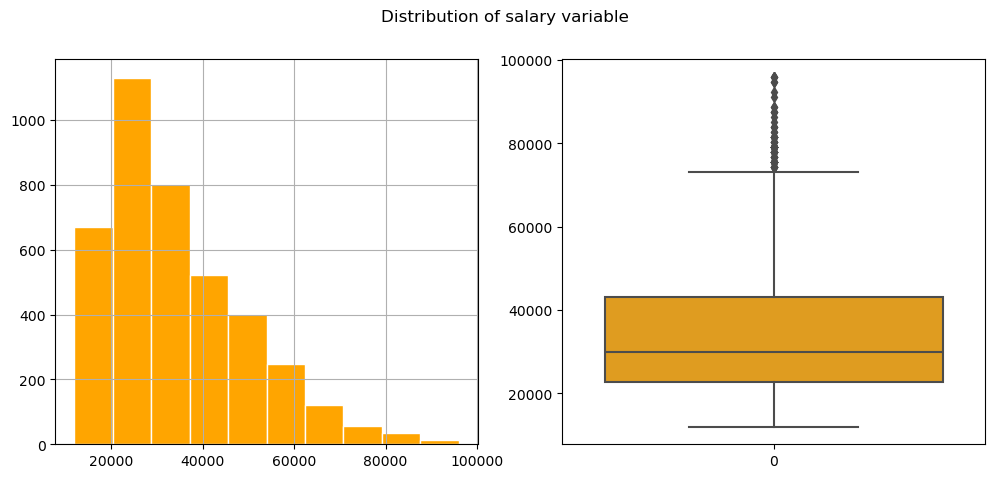

In [374]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

train_quit['salary'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = train_quit['salary'], color='orange')

plt.suptitle('Distribution of salary variable')

In [375]:
train_quit['salary_l'] = np.log(train_quit['salary'])

Text(0.5, 0.98, 'Distribution of log(salary) variable')

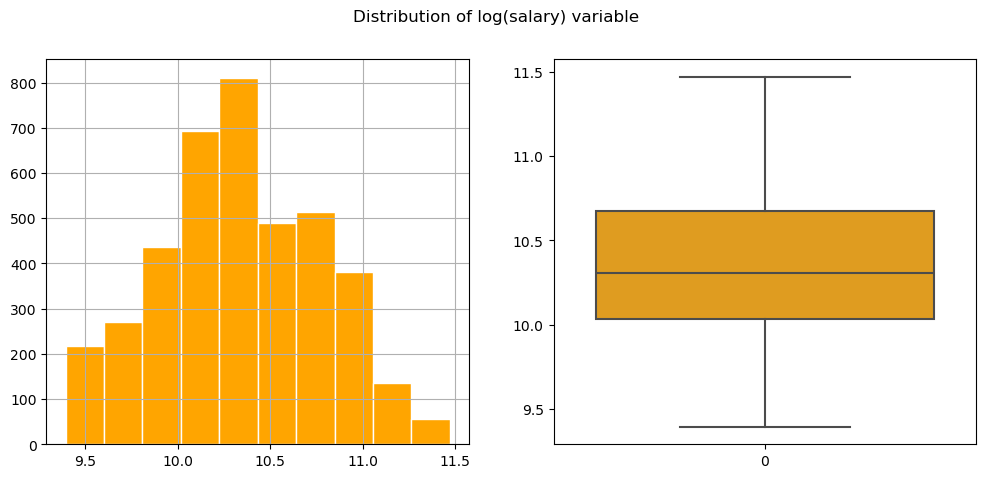

In [376]:
# визуализация непрерывных количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

train_quit['salary_l'].hist(ax=axes[0],
                    edgecolor='white', 
                    color='orange',
                   )

 
sns.boxplot(data = train_quit['salary_l'], color='orange')

plt.suptitle('Distribution of log(salary) variable')

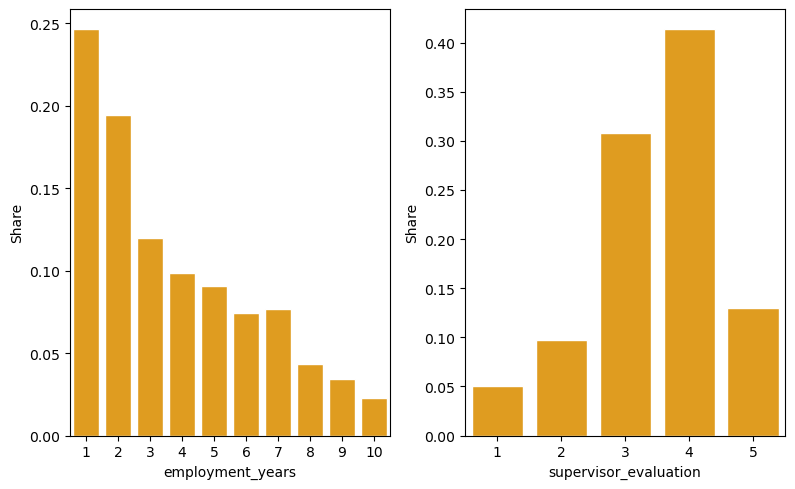

In [377]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_quit[['employment_years', 'supervisor_evaluation']].columns):
    data = pd.DataFrame(train_quit[column].value_counts(normalize=True)).reset_index()
    data.columns=[f'{column}', 'proportion']
    sns.barplot(data = data, x = f'{column}', y= 'proportion', ax=axes[i],
                    edgecolor='white', 
                    color='orange'
                   )

 
    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Share') 
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

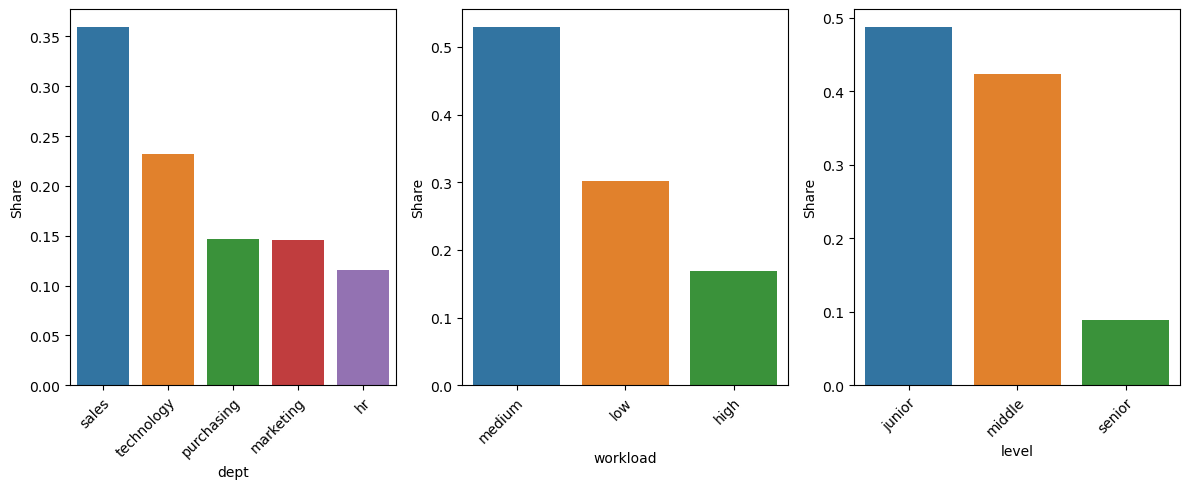

In [378]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_quit[['dept', 'workload', 'level']].columns):
    df = pd.DataFrame(train_quit[column].value_counts(normalize=True)).reset_index()
    sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Share') 
    axes[i].set_xticklabels(
        axes[i].get_xticklabels(), 
        rotation=45,          
        ha='right',           
        rotation_mode='anchor' 
    )

plt.tight_layout()

plt.show()

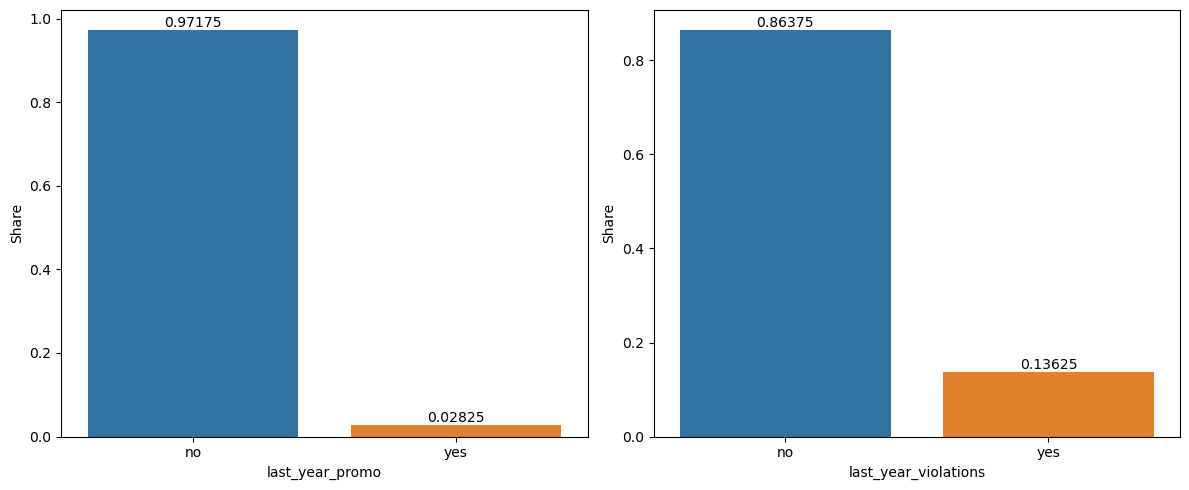

In [379]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(train_quit[['last_year_promo', 'last_year_violations']].columns):
    df = pd.DataFrame(train_quit[column].value_counts(normalize=True)).reset_index()
    ax = sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])
    ax.bar_label(ax.containers[0], fontsize=10)

    axes[i].set_xlabel(column) 
    axes[i].set_ylabel('Share') 

plt.tight_layout()

plt.show()

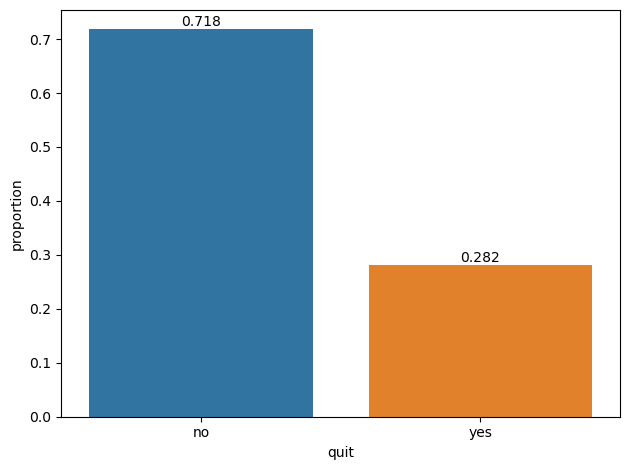

In [380]:
df = pd.DataFrame(train_quit['quit'].value_counts(normalize=True)).reset_index()
ax = sns.barplot(x = df['quit'], y = df['proportion'])
ax.bar_label(ax.containers[0], fontsize=10)


plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Matrix correlation coefficient phik in market_file (non-linear relations)')

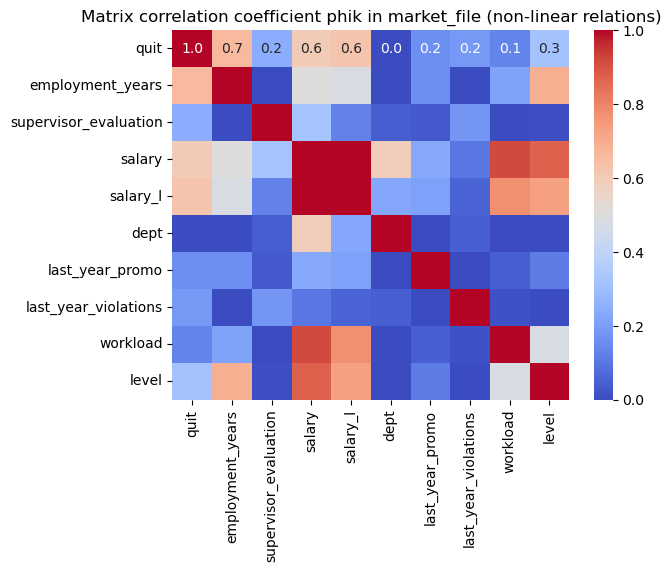

In [381]:
sns.heatmap(train_quit[["quit", 'employment_years', 'supervisor_evaluation','salary', 'salary_l', 'dept', 'last_year_promo', 'last_year_violations', 'workload', 'level']].phik_matrix(interval_cols=num_columns), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Matrix correlation coefficient phik in market_file (non-linear relations)')

In [382]:
train_quit.groupby(['quit'])['supervisor_evaluation'].mean()

quit
no     3.643106
yes    3.046099
Name: supervisor_evaluation, dtype: float64

In [383]:
train_quit.groupby(['quit', 'level'])['id'].count()

quit  level 
no    junior     946
      middle    1586
      senior     340
yes   junior    1003
      middle     108
      senior      17
Name: id, dtype: int64

In [384]:
train_quit.groupby(['quit', 'last_year_violations'])['id'].count()

quit  last_year_violations
no    no                      2555
      yes                      317
yes   no                       900
      yes                      228
Name: id, dtype: int64

In [385]:
train_quit.groupby(['quit', 'last_year_promo'])['id'].count()

quit  last_year_promo
no    no                 2760
      yes                 112
yes   no                 1127
      yes                   1
Name: id, dtype: int64

In [386]:
train_quit.groupby(['quit', 'workload'])['id'].count()

quit  workload
no    high         553
      low          689
      medium      1630
yes   high         121
      low          519
      medium       488
Name: id, dtype: int64

In [387]:
train_quit.groupby(['quit'])['salary'].mean()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

### Adding varibale 'job_satisfaction_rate'

In [388]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [389]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [390]:
df = pd.merge(test_target, test_target_quit, on = 'id', how='left')

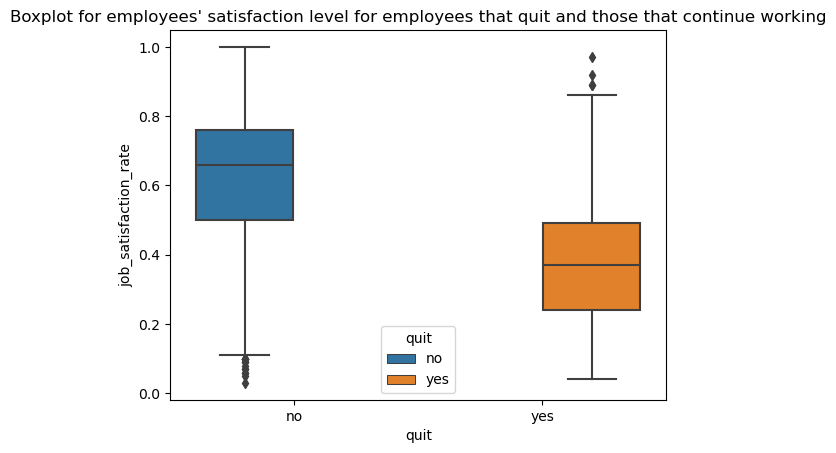

In [391]:
sns.boxplot(x=df["quit"], y=df["job_satisfaction_rate"], hue=df["quit"])
plt.title("Boxplot for employees' satisfaction level for employees that quit and those that continue working")
plt.show()

In [392]:
train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit   salary_l  
0                   no                      4   54000   no  10.896739  
1                   no                      4   27600   no  10.225571  
2                   no                      1   37200   no  10.524064  
3                  yes                      3   24000  yes  10.085809  
4                   no                      5   25200   no  10.134599

In [393]:
train_quit['supervisor_evaluation_class'] = train_quit['supervisor_evaluation'].apply(lambda x: 1 if x<=2 else 2 if x==3 else 3)

In [394]:
train_quit['job_satisfaction_rate'] = grid_2.predict(train_quit)

In [395]:
test_features['supervisor_evaluation_class'] = test_features['supervisor_evaluation'].apply(lambda x: 1 if x<=2 else 2 if x==3 else 3)

In [396]:
test_features['salary_l'] = np.log(test_features['salary'])

In [397]:
test_features['job_satisfaction_rate'] = grid_2.predict(test_features)

In [398]:
test_features.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary   salary_l  \
0                   no                      5   28800  10.268131   
1                   no                      4   30000  10.308953   
2                   no                      4   19200   9.862666   
3                   no                      4   19200   9.862666   
4                   no                      5   40800  10.616437   

   supervisor_evaluation_class  job_satisfaction_rate  
0                            3               0.866667  
1                            3               0.681429  
2                            3               0.654000  
3                            3               0.657500  
4                            3               0.760000

In [399]:
num_columns = ['employment_years', 'salary_l', 'job_satisfaction_rate']

Text(0.5, 1.0, 'Matrix correlation coefficient phik in market_file (non-linear relations)')

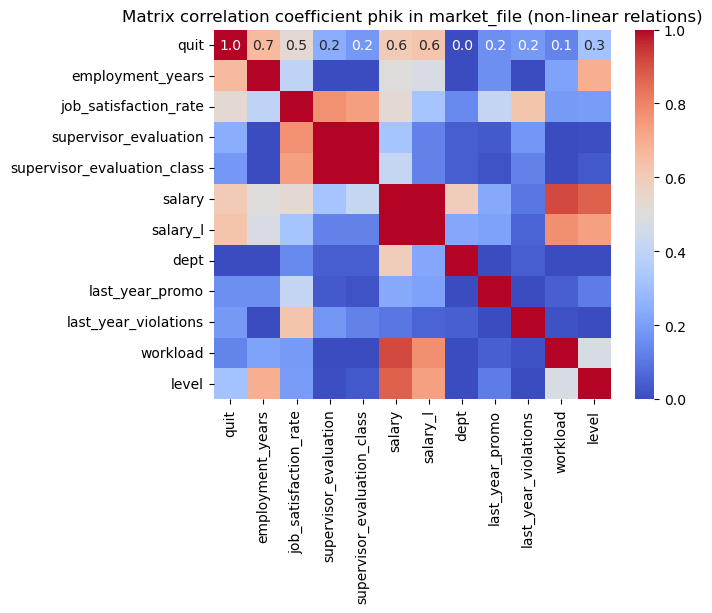

In [400]:
sns.heatmap(train_quit[["quit", 'employment_years', 'job_satisfaction_rate', 'supervisor_evaluation','supervisor_evaluation_class', 'salary', 'salary_l', 'dept', 'last_year_promo', 'last_year_violations', 'workload', 'level']].phik_matrix(interval_cols=num_columns), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Matrix correlation coefficient phik in market_file (non-linear relations)')

In [401]:
X = add_constant(train_job_satisf[num_columns])

In [402]:
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

const                    675.566534
employment_years           1.299488
salary_l                   1.261778
job_satisfaction_rate      1.048036
dtype: float64

#### Exploratory Data Analysis: Employee Attrition Profile

Based on the analysis of employees who have left the company, the following common characteristics were observed:
#
### Profile of an Employee Likely to Leave

- **Short tenure**: Typically worked at the company for a relatively short period
- **No recent promotion**: Did not receive a promotion in the past year
- **Policy violations**: Had violations of employment terms within the last year
- **Low supervisor evaluation**: Average performance rating from supervisor is around 3 out of 10
- **Low salary**: Average monthly salary is approximately 24,000
- **Light workload**: Generally reports a low workload level
- **Low job satisfaction**: Average satisfaction rate is below 0.4

These findings provide a foundation for building a predictive model and can also support targeted HR interventions to reduce attrition risk.

### Predicting model

In [403]:
train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit   salary_l  \
0                   no                      4   54000   no  10.896739   
1                   no                      4   27600   no  10.225571   
2                   no                      1   37200   no  10.524064   
3                  yes                      3   24000  yes  10.085809   
4                   no                      5   25200   no  10.134599   

   supervisor_evaluation_class  job_satisfaction_rate  
0                            3               0.730000  
1                            3               0.840769  
2                            1               0.340000  
3                            2               0.340000  
4                            3               0.690000

In [404]:
train_quit['quit'] = train_quit['quit'].apply(lambda x: 1 if x=='yes' else 0)

In [405]:
X = train_quit.drop(columns=['id', 'quit', 'salary', 'supervisor_evaluation'])
y = train_quit['quit']

In [406]:
num_columns = ['employment_years', 'salary_l', 'job_satisfaction_rate']
ohe_columns = ['dept','last_year_promo', 'last_year_violations', 'supervisor_evaluation_class']
ord_columns = ['workload', 'level']

In [407]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan,
                      strategy='most_frequent')
        ),
         ('ohe',
         OneHotEncoder(drop='first', 
                      handle_unknown = 'ignore',
                      sparse_output = False)
         )
    ]
)

In [408]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
         SimpleImputer(missing_values=np.nan,
                      strategy='most_frequent')
        ),
        ('ord',
         OrdinalEncoder(categories=[
             ['low', 'medium', 'high'],
             ['junior', 'middle', 'senior']
         ],
                       handle_unknown = 'use_encoded_value',
                       unknown_value = np.nan)
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values = np.nan, 
                          strategy = 'most_frequent')
        )]
)

In [409]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

In [410]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('resampler', SMOTE(random_state=RANDOM_STATE)),
        ('models', 'passthrough')
    ]
)

In [411]:
param_grid = [
    {
        'models':[LogisticRegression()],
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(2,11),
        'models__min_samples_split':range(2,7),
        'models__min_samples_leaf':range(1,5),
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(1,20),
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models' : [SVC(probability=True, random_state = RANDOM_STATE)],
        'models__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [412]:
grid_quit1 = RandomizedSearchCV(
    pipe_final, 
    param_distributions = param_grid,
    cv = 5, 
    scoring = 'roc_auc',
    n_jobs=-1
)

In [413]:
grid_quit1.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations',
                                                                                'supervisor_...
                                         'models__n_neighbors': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'resampler__k_neighbors': range(1, 10)},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'resampler__k_neighbors': range(1, 10)}],
                   scoring='roc_auc')

In [414]:
grid_quit1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'supervisor_evaluation_class']),
                                                 ('ord',
                                                  Pipelin...
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'salary_l',
                                                   'job_satisfaction_rate'])])),
                ('resampler', SMOTE(k_neighbors=9, random_state=42)),
                ('models',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=4,
                                        min_samples_split=5,
                                        random_state=42))])

In [415]:
results = pd.DataFrame(grid_quit1.cv_results_)

In [416]:
results.sort_values(by='rank_test_score')[['rank_test_score', 'mean_test_score','params']].head(10)

rank_test_score  mean_test_score  \
0                1         0.925572   
5                2         0.924935   
3                3         0.924563   
4                4         0.922949   
1                5         0.920382   
8                6         0.920115   
6                7         0.918765   
9                8         0.909953   
2                9         0.886358   
7               10         0.722574   

                                                                                                                                                                                                                                                                                         params  
0   {'resampler__k_neighbors': 9, 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
5     {'resampler__k_neighbors': 5, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 4, 'models__max_depth': 9, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
3   {'resampler__k_neighbors': 2, 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
4     {'resampler__k_neighbors': 4, 'preprocessor__num': RobustScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_depth': 8, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
1     {'resampler__k_neighbors': 4, 'preprocessor__num': RobustScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 3, 'models__max_depth': 4, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
8     {'resampler__k_neighbors': 6, 'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 3, 'models__max_depth': 7, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
6      {'resampler__k_neighbors': 8, 'preprocessor__num': 'passthrough', 'models__min_samples_split': 3, 'models__min_samples_leaf': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
9  {'resampler__k_neighbors': 5, 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 1, 'models__max_depth': 10, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
2     {'resampler__k_neighbors': 4, 'preprocessor__num': RobustScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 2, 'models__max_depth': 2, 'models': DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                       random_state=42)}  
7                                                                                                                                             {'resampler__k_neighbors': 3, 'preprocessor__num': MinMaxScaler(), 'models__kernel': 'sigmoid', 'models': SVC(probability=True, random_state=42)}

In [417]:
print('Roc_auc value for the best model:\n', grid_quit1.best_score_)
print('\nThe best model and its parameters:\n\n', grid_quit1.best_estimator_) 

Roc_auc value for the best model:
 0.9255718506057571

The best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                           

In [418]:
best_pipe = grid_quit1.best_estimator_

In [419]:
best_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations',
                                                   'supervisor_evaluation_class']),
                                                 ('ord',
                                                  Pipelin...
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'salary_l',
                                                   'job_satisfaction_rate'])])),
                ('resampler', SMOTE(k_neighbors=9, random_state=42)),
                ('models',
                 DecisionTreeClassifier(max_depth=6, min_samples_leaf=4,
                                        min_samples_split=5,
                                        random_state=42))])

In [420]:
def predict_wrapper(X):
    if isinstance(X, pd.DataFrame):
        # Ensure DataFrame has correct original columns
        return best_pipe.predict_proba(X[num_columns + ohe_columns+ ord_columns])
    else:
        # For numpy arrays, use the preprocessor's input shape
        if X.shape[1] == len(num_columns + ohe_columns+ ord_columns):
            # Raw features before encoding
            X_df = pd.DataFrame(X, columns=num_columns + ohe_columns+ord_columns)
            return best_pipe.predict_proba(X_df)
        elif X.shape[1] == len(true_feature_names):
            # Already transformed features
            return best_pipe.named_steps['models'].predict_proba(X)
        else:
            raise ValueError(f"Input has {X.shape[1]} features, expected {len(num_columns + ohe_columns)} or {len(true_feature_names)}")


In [421]:
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if (name == 'num')|(name == 'ord'):
            if transformer == 'passthrough':
                feature_names.extend(features)
            else:
                feature_names.extend(features)  # Numerical features keep original names
        elif name == 'ohe':
            if hasattr(transformer, 'get_feature_names_out'):
                # Get one-hot encoded feature names
                ohe_features = transformer.get_feature_names_out(features)
                feature_names.extend(ohe_features)
            else:
                feature_names.extend(features)
    return feature_names

In [422]:
feature_names = get_feature_names(best_pipe.named_steps['preprocessor'])
feature_names

['dept_marketing',
 'dept_purchasing',
 'dept_sales',
 'dept_technology',
 'last_year_promo_yes',
 'last_year_violations_yes',
 'supervisor_evaluation_class_2',
 'supervisor_evaluation_class_3',
 'workload',
 'level',
 'employment_years',
 'salary_l',
 'job_satisfaction_rate']

In [423]:
X_transformed = best_pipe.named_steps['preprocessor'].transform(X)
true_feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
print(f"Actual number of features: {len(true_feature_names)}")
print(true_feature_names)

Actual number of features: 13
['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_sales'
 'ohe__dept_technology' 'ohe__last_year_promo_yes'
 'ohe__last_year_violations_yes' 'ohe__supervisor_evaluation_class_2'
 'ohe__supervisor_evaluation_class_3' 'ord__workload' 'ord__level'
 'num__employment_years' 'num__salary_l' 'num__job_satisfaction_rate']


In [424]:
background_data = shap.utils.sample(X_transformed, 100)

In [425]:
explainer = shap.Explainer(
    model=predict_wrapper,
    masker=background_data,
    feature_names=true_feature_names  # Use actual output feature names
)

In [426]:
shap_values = explainer(X_transformed)

PermutationExplainer explainer: 4001it [01:47, 33.69it/s]                                                              


In [427]:
shap_2d = shap_values[..., 1] 

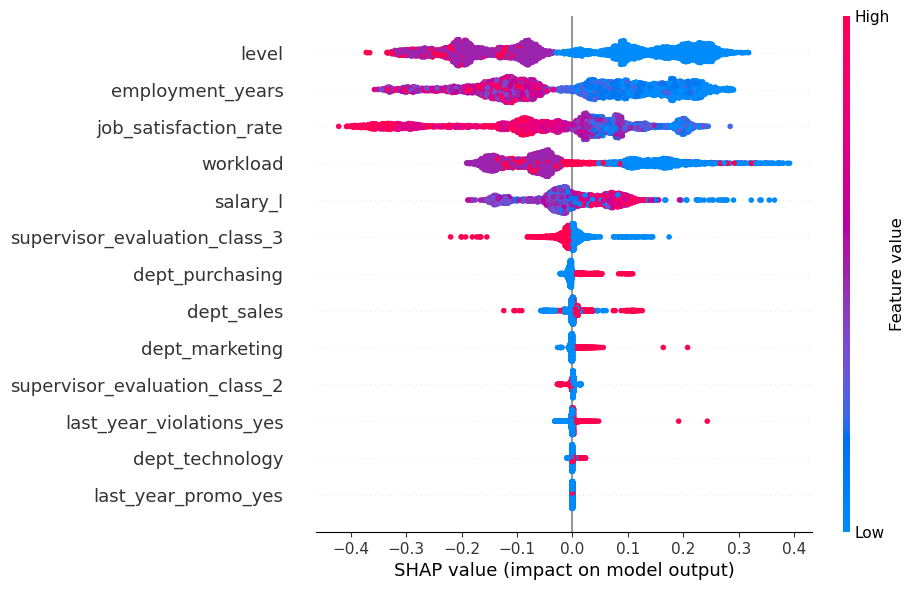

In [428]:
shap.plots.beeswarm(shap.Explanation(values=shap_2d, feature_names=feature_names), max_display=13)

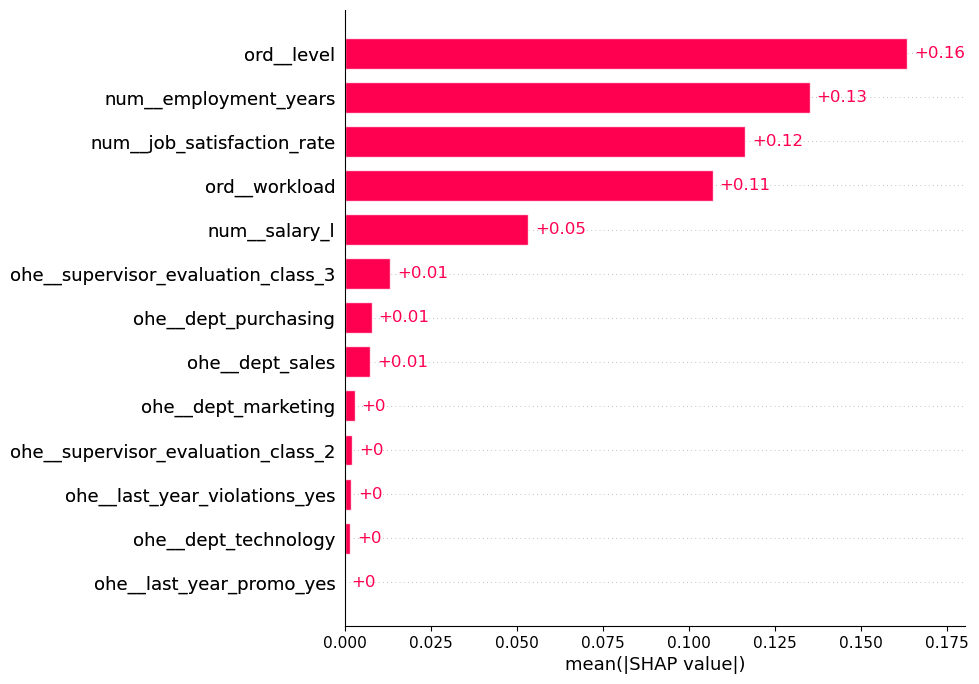

In [429]:
shap.plots.bar(shap_2d, max_display=13)

### Model setting

In [430]:
X = train_quit.drop(columns=['id', 'quit', 'salary', 'supervisor_evaluation', 'last_year_promo'])
y = train_quit['quit']

In [431]:
num_columns = ['employment_years', 'salary_l', 'job_satisfaction_rate']
ohe_columns = ['dept', 'supervisor_evaluation_class', 'last_year_violations']
ord_columns = ['workload', 'level']

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify = y)

In [433]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan,
                      strategy='most_frequent')
        ),
         ('ohe',
         OneHotEncoder(drop='first', 
                      handle_unknown = 'ignore',
                      sparse_output = False)
         )
    ]
)

In [434]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord',
         SimpleImputer(missing_values=np.nan,
                      strategy='most_frequent')
        ),
        ('ord',
         OrdinalEncoder(categories=[
             ['low', 'medium', 'high'],
             ['junior', 'middle', 'senior']
         ],
                       handle_unknown = 'use_encoded_value',
                       unknown_value = np.nan)
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values = np.nan, 
                          strategy = 'most_frequent')
        )]
)

In [435]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

In [436]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('resampler', SMOTE(random_state = RANDOM_STATE)),
        ('models', 'passthrough')
    ]
)

In [437]:
param_grid = [
    {
        'models':[LogisticRegression()],
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(2,11),
        'models__min_samples_split':range(2,7),
        'models__min_samples_leaf':range(1,5),
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num':[StandardScaler(),
                            MinMaxScaler(),
                            RobustScaler(),
                            'passthrough']
    },
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(1,20),
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models' : [SVC(probability=True, random_state = RANDOM_STATE)],
        'models__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
        'resampler__k_neighbors': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [438]:
grid_quit1 = RandomizedSearchCV(
    pipe_final, 
    param_distributions = param_grid,
    cv = 5, 
    scoring = 'roc_auc',
    n_jobs=-1
)

In [439]:
X_train.head()

dept   level workload  employment_years last_year_violations  \
144        sales  middle      low                 5                   no   
1577  purchasing  middle   medium                 6                  yes   
3851  technology  middle      low                 4                   no   
1907          hr  middle   medium                 4                   no   
184   purchasing  junior      low                 3                   no   

       salary_l  supervisor_evaluation_class  job_satisfaction_rate  
144    9.862666                            3                  0.654  
1577  10.422281                            1                  0.180  
3851  10.422281                            2                  0.338  
1907  10.753638                            3                  0.640  
184    9.798127                            2                  0.538

In [440]:
grid_quit1.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'supervisor_evaluation_class',
                                                                                'last_year_violations']...
                                         'models__n_neighbors': range(1, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'resampler__k_neighbors': range(1, 10)},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                                         'resampler__k_neighbors': range(1, 10)}],
                   scoring='roc_auc')

In [441]:
print('Roc_auc value for the best model:\n', grid_quit1.best_score_)
print('\nThe best model and its parameters:\n\n', grid_quit1.best_estimator_) 

Roc_auc value for the best model:
 0.9289284660953758

The best model and its parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'supervisor_evaluation_class',
                                       

In [442]:
best_pipe = grid_quit1.best_estimator_

In [443]:
y_test_pred = grid_quit1.predict_proba(X_test)[:,1]
print(f'Roc-auc value for the test sample: {roc_auc_score(y_test, y_test_pred)}')

Roc-auc value for the test sample: 0.9228748098540074


In [444]:
def predict_wrapper(X):
    if isinstance(X, pd.DataFrame):
        # Ensure DataFrame has correct original columns
        return best_pipe.predict_proba(X[num_columns + ohe_columns+ ord_columns])
    else:
        # For numpy arrays, use the preprocessor's input shape
        if X.shape[1] == len(num_columns + ohe_columns+ ord_columns):
            # Raw features before encoding
            X_df = pd.DataFrame(X, columns=num_columns + ohe_columns+ord_columns)
            return best_pipe.predict_proba(X_df)
        elif X.shape[1] == len(true_feature_names):
            # Already transformed features
            return best_pipe.named_steps['models'].predict_proba(X)
        else:
            raise ValueError(f"Input has {X.shape[1]} features, expected {len(num_columns + ohe_columns)} or {len(true_feature_names)}")


In [445]:
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if (name == 'num')|(name == 'ord'):
            if transformer == 'passthrough':
                feature_names.extend(features)
            else:
                feature_names.extend(features)  # Numerical features keep original names
        elif name == 'ohe':
            if hasattr(transformer, 'get_feature_names_out'):
                # Get one-hot encoded feature names
                ohe_features = transformer.get_feature_names_out(features)
                feature_names.extend(ohe_features)
            else:
                feature_names.extend(features)
    return feature_names

In [446]:
feature_names = get_feature_names(best_pipe.named_steps['preprocessor'])
feature_names

['dept_marketing',
 'dept_purchasing',
 'dept_sales',
 'dept_technology',
 'supervisor_evaluation_class_2',
 'supervisor_evaluation_class_3',
 'last_year_violations_yes',
 'workload',
 'level',
 'employment_years',
 'salary_l',
 'job_satisfaction_rate']

In [447]:
X_train_transformed = best_pipe.named_steps['preprocessor'].transform(X_train)
true_feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()
print(f"Actual number of features: {len(true_feature_names)}")
print(true_feature_names)

Actual number of features: 12
['ohe__dept_marketing' 'ohe__dept_purchasing' 'ohe__dept_sales'
 'ohe__dept_technology' 'ohe__supervisor_evaluation_class_2'
 'ohe__supervisor_evaluation_class_3' 'ohe__last_year_violations_yes'
 'ord__workload' 'ord__level' 'num__employment_years' 'num__salary_l'
 'num__job_satisfaction_rate']


In [448]:
background_data = shap.utils.sample(X_train_transformed, 100)

In [449]:
explainer = shap.Explainer(
    model=predict_wrapper,
    masker=background_data,
    feature_names=true_feature_names  # Use actual output feature names
)

In [450]:
X_test_transformed = best_pipe.named_steps['preprocessor'].transform(X_test)

In [451]:
shap_values = explainer(X_test_transformed)

PermutationExplainer explainer: 1001it [2:27:20,  8.85s/it]                                                            


In [452]:
shap_2d = shap_values[..., 1] 

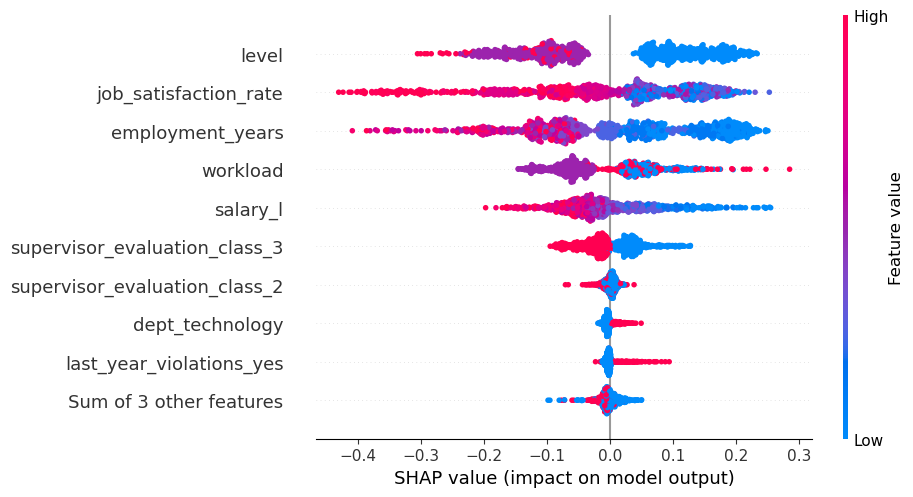

In [453]:
shap.plots.beeswarm(shap.Explanation(values=shap_2d, feature_names=feature_names))

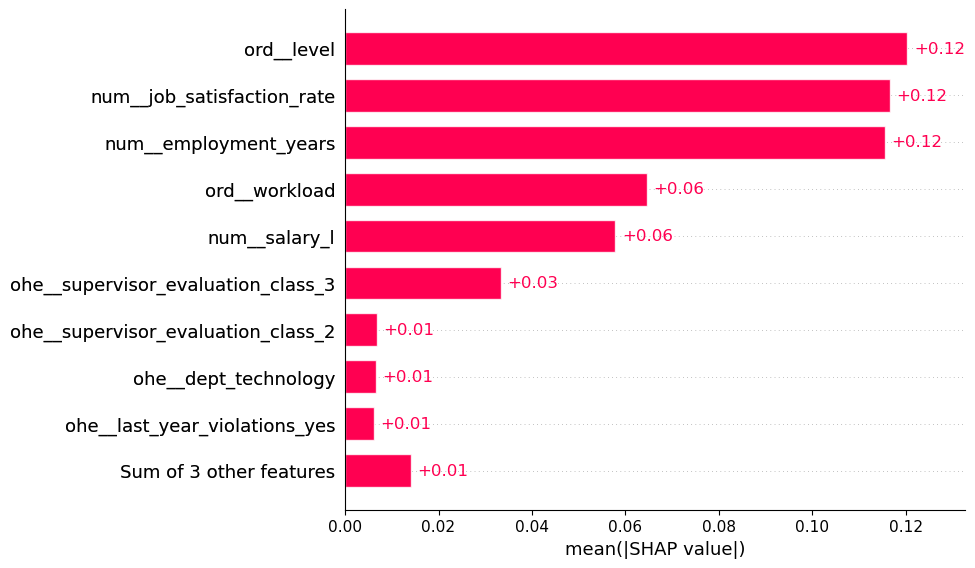

In [454]:
shap.plots.bar(shap_2d)

### Model testing

In [455]:
X_test = test_features.sort_values(by='id', ascending = True)
X_test.head()

id        dept   level workload  employment_years last_year_promo  \
1172  100298          hr  junior      low                 2              no   
852   100480   marketing  junior      low                 4              no   
848   100503  purchasing  middle     high                 5              no   
524   100610       sales  middle   medium                 5              no   
476   100692       sales  middle     high                 6              no   

     last_year_violations  supervisor_evaluation  salary   salary_l  \
1172                   no                      4   19200   9.862666   
852                    no                      4   16800   9.729134   
848                    no                      4   55200  10.918718   
524                    no                      4   43200  10.673596   
476                    no                      4   48000  10.778956   

      supervisor_evaluation_class  job_satisfaction_rate  
1172                            3               0.817500  
852                             3               0.842000  
848                             3               0.746667  
524                             3               0.808571  
476                             3               0.696000

In [456]:
y_test = test_target_quit.sort_values(by='id', ascending=True)
y_test.head(5)

id quit
1566  100298   no
491   100480   no
802   100503   no
725   100610   no
319   100692   no

In [457]:
y_test['quit'] = y_test['quit'].apply(lambda x: 1 if x=='yes' else 0)

In [458]:
y_test = y_test['quit']

In [459]:
y_pred = grid_quit1.predict_proba(X_test[['employment_years', 'salary_l', 'job_satisfaction_rate', 'supervisor_evaluation_class', 'workload', 'level', 'dept', 'last_year_violations']])[:,1]

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [460]:
roc_auc_score(y_test, y_pred)

0.9163357632509532

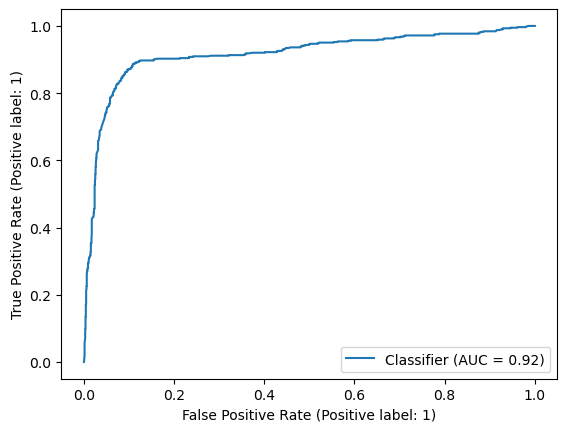

In [461]:
RocCurveDisplay.from_predictions(y_test, y_pred)

## Final Summary


### Project Objectives

- **Objective 1:** Develop a predictive model to estimate employee job satisfaction  
- **Objective 2:** Develop a predictive model to estimate the probability of employee attrition

---


--
### 2. Data Preprocessing

- Missing values and both explicit and implicit duplicates were identified and handled across all datasets
- Categorical values were corrected for consistency (e.g., typo in `level`)
- Features were encoded and scaled appropriately for modeling tas

---

### 3. Exploratory Data Analysis (EDA) and Key Observations

- The **average monthly salary** is around **34,000 RUB**, with a **left-skewed distribution**  
  → A log transformation was applied to stabilize the variance in regression and classification models  
- Most employees have been with the company for **less than 5 years**
- The **average supervisor evaluation** is approximately **4 out of 5**
- Department distribution:  
  - **Sales**: 37%  
  - **Technical**: 22%  
  - **Marketing** and **Procurement**: ~15% each  
  - **HR**: 12%
- Strong linear correlations were found between **supervisor evaluation**, **policy violations**, and the **tet variables**

---

### 4. Job Satisfaction Prediction

- A regression model was built using `DecisionTreeRegressor` after model comparison
- Residual analysis confirmed stability of predictions
- The model achieved the target accuracy with **SE ≤ 15%** on test data

---

### 5. Key Factors Influencing Job Satisfaction

- Supervisor rating above 3 increases satisfaction by an average of **0.16**
- **Years at the company** positively affect satisfaction
- **Higher job levels** tend to correlate with **lower satisfaction**
- **Higher salary** contributes positively to satisfaction
- **Policy violations** and **higher workload** negatively impact satisfaction
- **Technical department** employees are generally less satisfied, while **sales** employees report higher satisfaction

> **Supervisor evaluation is the most influential factorin predicting employee satisfaction

---

### 6. Employee Attrition Prediction

- Preprocessing was applied similarly, including handling missing values and duplicates
- EDA was extended to include the predicted satisfaction level as a feature
- Addressed class imbalance using **oversampling techniques**
- The best-performing model was a `DecisionTreeClassifier` with tuned hyperparameters
- Feature importance was analyzed using **SHAP values**, and relevant features were selected
- The final model achid the **target ROC AUC score** on the test set

---

### 7. Business Recommendations

- The models enable the HR department to **predict job satisfaction and attrition risk**, allowing proactive measures to reduce turnover
- Special attention should be paid to employees in **higher-level positions**, as they show a higher risk of attrition — further analysis is needed to identify causes and reduce leadership-level churn
- A **long-term strategy to improve employee satisfaction** is recommended to help mitigate attrition overall
- **Workload monitoring and management** is essential, as excessive workload is a key factor increasing the likelihood of resignation

---

These insights can serve as the foundation for a data-driven HR policy aimed at improving employee retention, satisfaction, and organizational stability.